# Models Comparison for TinyML

In [1]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
choosenIndex = 0

In [3]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
n_labels = 2 + choosenIndex
samples = 150
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [5]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [6]:
y = np.array([int(el) for el in y])
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(60, 32)
(60,)


In [8]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

In [9]:
X_test

array([[1681.61, 1793.95, 1284.47,  688.31,  831.26,  326.18,  198.29,
         185.82,   80.8 ,  120.12,   73.22,  118.04,  192.28,  194.27,
         315.88,  310.18,  335.88,  414.11,  434.93,  338.98,  266.97,
         308.11,  283.55,  275.53,  331.38,  402.95,  195.61,  377.56,
         174.6 ,  100.59,   93.3 ,  162.98],
       [1146.01, 1995.76, 2296.28, 2049.1 , 1824.41, 1645.48, 1476.07,
        1203.49, 1152.23,  550.19,  211.05,  243.95,  253.25,  235.52,
         245.71,  153.87,  158.24,  123.83,  103.55,   39.04,   46.68,
          34.29,   51.92,   31.7 ,  120.94,   75.64,   96.03,   42.45,
          76.5 ,  174.95,  163.42,  119.99],
       [1473.04, 2135.31, 1910.89, 2114.22, 1961.72, 2522.15, 2194.22,
        1581.67, 2193.98, 2572.83, 2253.28,  680.13,  309.38,  236.37,
         120.15,  137.79,   69.64,   63.77,   24.43,   25.14,  101.39,
          68.47,   91.94,   92.24,   87.96,  114.5 ,  130.06,  123.63,
         152.26,  102.42,  157.31,  113.33],
       [1649.

## Model Spotting

In [10]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [27]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.000001, random_state=seed)))
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))


In [28]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,63 0,08
LR - 0,66 0,10
CART - 0,71 0,05
SVC - 0,80 0,07
RF - 0,80 0,08


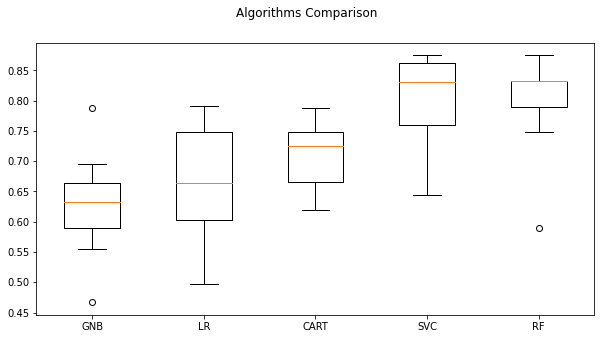

In [29]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [30]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if choosenIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.70      0.87      0.78        30
           1       0.83      0.63      0.72        30

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        30
           1       0.67      0.67      0.67        30

    accuracy                           0.67        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.67      0.67      0.67        60

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        30
           1       0.77      0.80      0.79        30

    accuracy          

## Valutazione Inferance Rate medio (|X_test| = 40)

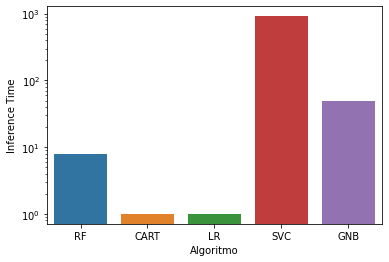

In [31]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

## Memoria occupata

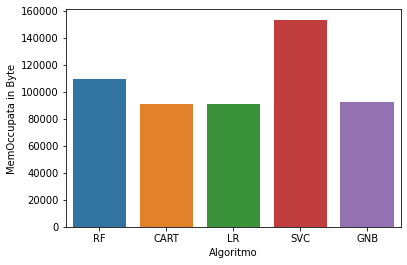

In [32]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [34]:
EPOCHS = 1000 
BATCH_SIZE = 4 #16 with 5 labels
learn_rate = 0.0001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [35]:
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 10,018
Trainable params: 10,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
54/54 [==============================] - 0s 509us/step - loss: 132.8391 - accuracy: 0.5417
Epoch 2/100

54/54 [==============================] - 0s 462us/step - loss: 11.5556 - accuracy: 0.7222
Epoch 71/1000
54/54 [==============================] - 0s 454us/step - loss: 10.8172 - accuracy: 0.7176
Epoch 72/1000
54/54 [==============================] - 0s 496us/step - loss: 10.5732 - accuracy: 0.6574
Epoch 73/1000
54/54 [==============================] - 0s 422us/step - loss: 12.7101 - accuracy: 0.6991
Epoch 74/1000
54/54 [==============================] - 0s 639us/step - loss: 8.6755 - accuracy: 0.7407
Epoch 75/1000
54/54 [==============================] - 0s 570us/step - loss: 10.4341 - accuracy: 0.7037
Epoch 76/1000
54/54 [==============================] - 0s 481us/step - loss: 12.8828 - accuracy: 0.6806
Epoch 77/1000
54/54 [==============================] - 0s 487us/step - loss: 13.0114 - accuracy: 0.7130
Epoch 78/1000
54/54 [==============================] - 0s 424us/step - loss: 8.2657 - accuracy: 0.7454
Epoch 79/1000
54/54 [==============================] - 0s 483us/step - loss: 10.

54/54 [==============================] - 0s 458us/step - loss: 2.1493 - accuracy: 0.6898
Epoch 150/1000
54/54 [==============================] - 0s 448us/step - loss: 3.0741 - accuracy: 0.6852
Epoch 151/1000
54/54 [==============================] - 0s 485us/step - loss: 2.6933 - accuracy: 0.6852
Epoch 152/1000
54/54 [==============================] - 0s 598us/step - loss: 1.7799 - accuracy: 0.7315
Epoch 153/1000
54/54 [==============================] - 0s 590us/step - loss: 1.9854 - accuracy: 0.6991
Epoch 154/1000
54/54 [==============================] - 0s 471us/step - loss: 1.7513 - accuracy: 0.7593
Epoch 155/1000
54/54 [==============================] - 0s 456us/step - loss: 1.8297 - accuracy: 0.7083
Epoch 156/1000
54/54 [==============================] - 0s 457us/step - loss: 1.7139 - accuracy: 0.6991
Epoch 157/1000
54/54 [==============================] - 0s 456us/step - loss: 1.6166 - accuracy: 0.7315
Epoch 158/1000
54/54 [==============================] - 0s 437us/step - loss: 1

Epoch 228/1000
54/54 [==============================] - 0s 489us/step - loss: 0.7984 - accuracy: 0.6944
Epoch 229/1000
54/54 [==============================] - 0s 470us/step - loss: 0.5462 - accuracy: 0.7222
Epoch 230/1000
54/54 [==============================] - 0s 471us/step - loss: 0.5474 - accuracy: 0.7269
Epoch 231/1000
54/54 [==============================] - 0s 727us/step - loss: 0.6372 - accuracy: 0.6898
Epoch 232/1000
54/54 [==============================] - 0s 491us/step - loss: 0.5978 - accuracy: 0.7315
Epoch 233/1000
54/54 [==============================] - 0s 472us/step - loss: 0.6007 - accuracy: 0.7176
Epoch 234/1000
54/54 [==============================] - 0s 468us/step - loss: 0.5134 - accuracy: 0.7269
Epoch 235/1000
54/54 [==============================] - 0s 458us/step - loss: 0.5790 - accuracy: 0.7407
Epoch 236/1000
54/54 [==============================] - 0s 486us/step - loss: 0.6818 - accuracy: 0.7269
Epoch 237/1000
54/54 [==============================] - 0s 486us

54/54 [==============================] - 0s 473us/step - loss: 0.4541 - accuracy: 0.7500
Epoch 307/1000
54/54 [==============================] - 0s 468us/step - loss: 0.4588 - accuracy: 0.7222
Epoch 308/1000
54/54 [==============================] - 0s 474us/step - loss: 0.4758 - accuracy: 0.7315
Epoch 309/1000
54/54 [==============================] - 0s 681us/step - loss: 0.4678 - accuracy: 0.7315
Epoch 310/1000
54/54 [==============================] - 0s 481us/step - loss: 0.5180 - accuracy: 0.7269
Epoch 311/1000
54/54 [==============================] - 0s 426us/step - loss: 0.5618 - accuracy: 0.7361
Epoch 312/1000
54/54 [==============================] - 0s 455us/step - loss: 0.4626 - accuracy: 0.7361
Epoch 313/1000
54/54 [==============================] - 0s 431us/step - loss: 0.4615 - accuracy: 0.7454
Epoch 314/1000
54/54 [==============================] - 0s 457us/step - loss: 0.4509 - accuracy: 0.7500
Epoch 315/1000
54/54 [==============================] - 0s 432us/step - loss: 0

54/54 [==============================] - 0s 471us/step - loss: 0.4498 - accuracy: 0.7546
Epoch 385/1000
54/54 [==============================] - 0s 416us/step - loss: 0.5647 - accuracy: 0.7176
Epoch 386/1000
54/54 [==============================] - 0s 470us/step - loss: 0.4743 - accuracy: 0.7500
Epoch 387/1000
54/54 [==============================] - 0s 413us/step - loss: 0.4505 - accuracy: 0.7500
Epoch 388/1000
54/54 [==============================] - 0s 488us/step - loss: 0.4440 - accuracy: 0.7500
Epoch 389/1000
54/54 [==============================] - 0s 511us/step - loss: 0.4430 - accuracy: 0.7500
Epoch 390/1000
54/54 [==============================] - 0s 583us/step - loss: 0.4343 - accuracy: 0.7593
Epoch 391/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.4583 - accuracy: 0.7361
Epoch 392/1000
54/54 [==============================] - 0s 566us/step - loss: 0.4853 - accuracy: 0.7315
Epoch 393/1000
54/54 [==============================] - 0s 462us/step - loss: 0.4

Epoch 463/1000
54/54 [==============================] - 0s 457us/step - loss: 0.4535 - accuracy: 0.7361
Epoch 464/1000
54/54 [==============================] - 0s 446us/step - loss: 0.4363 - accuracy: 0.7361
Epoch 465/1000
54/54 [==============================] - 0s 451us/step - loss: 0.4372 - accuracy: 0.7500
Epoch 466/1000
54/54 [==============================] - 0s 440us/step - loss: 0.4352 - accuracy: 0.7593
Epoch 467/1000
54/54 [==============================] - 0s 473us/step - loss: 0.4309 - accuracy: 0.7731
Epoch 468/1000
54/54 [==============================] - 0s 572us/step - loss: 0.4190 - accuracy: 0.7685
Epoch 469/1000
54/54 [==============================] - 0s 824us/step - loss: 0.4227 - accuracy: 0.7639
Epoch 470/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.4274 - accuracy: 0.7546
Epoch 471/1000
54/54 [==============================] - 0s 539us/step - loss: 0.4349 - accuracy: 0.7593
Epoch 472/1000
54/54 [==============================] - 0s 440us/s

54/54 [==============================] - 0s 469us/step - loss: 0.4252 - accuracy: 0.7593
Epoch 542/1000
54/54 [==============================] - 0s 472us/step - loss: 0.4306 - accuracy: 0.7500
Epoch 543/1000
54/54 [==============================] - 0s 469us/step - loss: 0.4288 - accuracy: 0.7639
Epoch 544/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4327 - accuracy: 0.7500
Epoch 545/1000
54/54 [==============================] - 0s 471us/step - loss: 0.4817 - accuracy: 0.7546
Epoch 546/1000
54/54 [==============================] - 0s 444us/step - loss: 0.4200 - accuracy: 0.7639
Epoch 547/1000
54/54 [==============================] - 0s 597us/step - loss: 0.4376 - accuracy: 0.7593
Epoch 548/1000
54/54 [==============================] - 0s 564us/step - loss: 0.4425 - accuracy: 0.7546
Epoch 549/1000
54/54 [==============================] - 0s 482us/step - loss: 0.4245 - accuracy: 0.7546
Epoch 550/1000
54/54 [==============================] - 0s 458us/step - loss: 0

54/54 [==============================] - 0s 479us/step - loss: 0.4128 - accuracy: 0.7639
Epoch 620/1000
54/54 [==============================] - 0s 439us/step - loss: 0.4131 - accuracy: 0.7639
Epoch 621/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4127 - accuracy: 0.7778
Epoch 622/1000
54/54 [==============================] - 0s 450us/step - loss: 0.4092 - accuracy: 0.7778
Epoch 623/1000
54/54 [==============================] - 0s 441us/step - loss: 0.4064 - accuracy: 0.7731
Epoch 624/1000
54/54 [==============================] - 0s 450us/step - loss: 0.4411 - accuracy: 0.7361
Epoch 625/1000
54/54 [==============================] - 0s 446us/step - loss: 0.4173 - accuracy: 0.7593
Epoch 626/1000
54/54 [==============================] - 0s 445us/step - loss: 0.4441 - accuracy: 0.7407
Epoch 627/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4573 - accuracy: 0.7546
Epoch 628/1000
54/54 [==============================] - 0s 449us/step - loss: 0

Epoch 698/1000
54/54 [==============================] - 0s 476us/step - loss: 0.4406 - accuracy: 0.7454
Epoch 699/1000
54/54 [==============================] - 0s 423us/step - loss: 0.4440 - accuracy: 0.7407
Epoch 700/1000
54/54 [==============================] - 0s 472us/step - loss: 0.4371 - accuracy: 0.7454
Epoch 701/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4107 - accuracy: 0.7685
Epoch 702/1000
54/54 [==============================] - 0s 458us/step - loss: 0.4393 - accuracy: 0.7593
Epoch 703/1000
54/54 [==============================] - 0s 469us/step - loss: 0.4321 - accuracy: 0.7593
Epoch 704/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4280 - accuracy: 0.7546
Epoch 705/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4336 - accuracy: 0.7639
Epoch 706/1000
54/54 [==============================] - 0s 474us/step - loss: 0.4298 - accuracy: 0.7593
Epoch 707/1000
54/54 [==============================] - 0s 469us

54/54 [==============================] - 0s 435us/step - loss: 0.4543 - accuracy: 0.7361
Epoch 777/1000
54/54 [==============================] - 0s 492us/step - loss: 0.4275 - accuracy: 0.7685
Epoch 778/1000
54/54 [==============================] - 0s 470us/step - loss: 0.4166 - accuracy: 0.7778
Epoch 779/1000
54/54 [==============================] - 0s 450us/step - loss: 0.4346 - accuracy: 0.7593
Epoch 780/1000
54/54 [==============================] - 0s 472us/step - loss: 0.4417 - accuracy: 0.7500
Epoch 781/1000
54/54 [==============================] - 0s 504us/step - loss: 0.4468 - accuracy: 0.7500
Epoch 782/1000
54/54 [==============================] - 0s 449us/step - loss: 0.4279 - accuracy: 0.7639
Epoch 783/1000
54/54 [==============================] - 0s 473us/step - loss: 0.4191 - accuracy: 0.7778
Epoch 784/1000
54/54 [==============================] - 0s 440us/step - loss: 0.4133 - accuracy: 0.7778
Epoch 785/1000
54/54 [==============================] - 0s 439us/step - loss: 0

Epoch 855/1000
54/54 [==============================] - 0s 462us/step - loss: 0.4447 - accuracy: 0.7500
Epoch 856/1000
54/54 [==============================] - 0s 468us/step - loss: 0.4145 - accuracy: 0.7731
Epoch 857/1000
54/54 [==============================] - 0s 441us/step - loss: 0.4385 - accuracy: 0.7454
Epoch 858/1000
54/54 [==============================] - 0s 471us/step - loss: 0.4250 - accuracy: 0.7593
Epoch 859/1000
54/54 [==============================] - 0s 447us/step - loss: 0.4121 - accuracy: 0.7639
Epoch 860/1000
54/54 [==============================] - 0s 450us/step - loss: 0.4157 - accuracy: 0.7639
Epoch 861/1000
54/54 [==============================] - 0s 493us/step - loss: 0.4216 - accuracy: 0.7593
Epoch 862/1000
54/54 [==============================] - 0s 436us/step - loss: 0.4377 - accuracy: 0.7407
Epoch 863/1000
54/54 [==============================] - 0s 493us/step - loss: 0.4387 - accuracy: 0.7546
Epoch 864/1000
54/54 [==============================] - 0s 460us

54/54 [==============================] - 0s 455us/step - loss: 0.4182 - accuracy: 0.7731
Epoch 934/1000
54/54 [==============================] - 0s 448us/step - loss: 0.4513 - accuracy: 0.7454
Epoch 935/1000
54/54 [==============================] - 0s 449us/step - loss: 0.4271 - accuracy: 0.7500
Epoch 936/1000
54/54 [==============================] - 0s 430us/step - loss: 0.4429 - accuracy: 0.7500
Epoch 937/1000
54/54 [==============================] - 0s 474us/step - loss: 0.4452 - accuracy: 0.7407
Epoch 938/1000
54/54 [==============================] - 0s 483us/step - loss: 0.4386 - accuracy: 0.7546
Epoch 939/1000
54/54 [==============================] - 0s 440us/step - loss: 0.4125 - accuracy: 0.7685
Epoch 940/1000
54/54 [==============================] - 0s 455us/step - loss: 0.4411 - accuracy: 0.7454
Epoch 941/1000
54/54 [==============================] - 0s 438us/step - loss: 0.4342 - accuracy: 0.7500
Epoch 942/1000
54/54 [==============================] - 0s 481us/step - loss: 0

54/54 [==============================] - 0s 466us/step - loss: 110.3805 - accuracy: 0.5231
Epoch 3/1000
54/54 [==============================] - 0s 464us/step - loss: 112.6000 - accuracy: 0.5046
Epoch 4/1000
54/54 [==============================] - 0s 421us/step - loss: 102.0126 - accuracy: 0.5324
Epoch 5/1000
54/54 [==============================] - 0s 480us/step - loss: 101.1006 - accuracy: 0.5324
Epoch 6/1000
54/54 [==============================] - 0s 451us/step - loss: 87.0825 - accuracy: 0.5000
Epoch 7/1000
54/54 [==============================] - 0s 447us/step - loss: 81.4112 - accuracy: 0.5463
Epoch 8/1000
54/54 [==============================] - 0s 461us/step - loss: 87.8468 - accuracy: 0.5417
Epoch 9/1000
54/54 [==============================] - 0s 459us/step - loss: 66.7139 - accuracy: 0.5880
Epoch 10/1000
54/54 [==============================] - 0s 452us/step - loss: 67.9754 - accuracy: 0.5926
Epoch 11/1000
54/54 [==============================] - 0s 460us/step - loss: 78.0

54/54 [==============================] - 0s 464us/step - loss: 8.3078 - accuracy: 0.7315
Epoch 82/1000
54/54 [==============================] - 0s 443us/step - loss: 10.0524 - accuracy: 0.6991
Epoch 83/1000
54/54 [==============================] - 0s 451us/step - loss: 8.4228 - accuracy: 0.7176
Epoch 84/1000
54/54 [==============================] - 0s 435us/step - loss: 9.9214 - accuracy: 0.6806
Epoch 85/1000
54/54 [==============================] - 0s 426us/step - loss: 8.0940 - accuracy: 0.6898
Epoch 86/1000
54/54 [==============================] - 0s 468us/step - loss: 6.1804 - accuracy: 0.7361
Epoch 87/1000
54/54 [==============================] - 0s 436us/step - loss: 5.8183 - accuracy: 0.7315
Epoch 88/1000
54/54 [==============================] - 0s 493us/step - loss: 6.2311 - accuracy: 0.7593
Epoch 89/1000
54/54 [==============================] - 0s 421us/step - loss: 7.9937 - accuracy: 0.6806
Epoch 90/1000
54/54 [==============================] - 0s 479us/step - loss: 6.3777 - 

54/54 [==============================] - 0s 461us/step - loss: 1.5678 - accuracy: 0.7685
Epoch 161/1000
54/54 [==============================] - 0s 430us/step - loss: 1.5309 - accuracy: 0.7917
Epoch 162/1000
54/54 [==============================] - 0s 447us/step - loss: 1.7993 - accuracy: 0.7731
Epoch 163/1000
54/54 [==============================] - 0s 454us/step - loss: 1.2985 - accuracy: 0.7685
Epoch 164/1000
54/54 [==============================] - 0s 450us/step - loss: 1.5703 - accuracy: 0.7639
Epoch 165/1000
54/54 [==============================] - 0s 451us/step - loss: 1.9030 - accuracy: 0.7315
Epoch 166/1000
54/54 [==============================] - 0s 444us/step - loss: 1.1779 - accuracy: 0.7917
Epoch 167/1000
54/54 [==============================] - 0s 452us/step - loss: 0.9092 - accuracy: 0.7500
Epoch 168/1000
54/54 [==============================] - 0s 452us/step - loss: 0.8543 - accuracy: 0.7824
Epoch 169/1000
54/54 [==============================] - 0s 439us/step - loss: 1

54/54 [==============================] - 0s 462us/step - loss: 0.5255 - accuracy: 0.7778
Epoch 239/1000
54/54 [==============================] - 0s 453us/step - loss: 0.5990 - accuracy: 0.7685
Epoch 240/1000
54/54 [==============================] - 0s 467us/step - loss: 0.7473 - accuracy: 0.7639
Epoch 241/1000
54/54 [==============================] - 0s 436us/step - loss: 0.4289 - accuracy: 0.8056
Epoch 242/1000
54/54 [==============================] - 0s 455us/step - loss: 0.4314 - accuracy: 0.7824
Epoch 243/1000
54/54 [==============================] - 0s 469us/step - loss: 0.4775 - accuracy: 0.7824
Epoch 244/1000
54/54 [==============================] - 0s 421us/step - loss: 0.7715 - accuracy: 0.7685
Epoch 245/1000
54/54 [==============================] - 0s 462us/step - loss: 0.5586 - accuracy: 0.7870
Epoch 246/1000
54/54 [==============================] - 0s 417us/step - loss: 0.5851 - accuracy: 0.7593
Epoch 247/1000
54/54 [==============================] - 0s 466us/step - loss: 0

Epoch 317/1000
54/54 [==============================] - 0s 475us/step - loss: 0.5270 - accuracy: 0.7963
Epoch 318/1000
54/54 [==============================] - 0s 453us/step - loss: 0.4201 - accuracy: 0.8194
Epoch 319/1000
54/54 [==============================] - 0s 504us/step - loss: 0.5118 - accuracy: 0.8241
Epoch 320/1000
54/54 [==============================] - 0s 451us/step - loss: 0.4221 - accuracy: 0.8056
Epoch 321/1000
54/54 [==============================] - 0s 459us/step - loss: 0.4461 - accuracy: 0.7917
Epoch 322/1000
54/54 [==============================] - 0s 463us/step - loss: 0.6554 - accuracy: 0.7870
Epoch 323/1000
54/54 [==============================] - 0s 472us/step - loss: 0.3897 - accuracy: 0.8194
Epoch 324/1000
54/54 [==============================] - 0s 485us/step - loss: 0.4487 - accuracy: 0.7963
Epoch 325/1000
54/54 [==============================] - 0s 486us/step - loss: 0.4711 - accuracy: 0.7870
Epoch 326/1000
54/54 [==============================] - 0s 463us

54/54 [==============================] - 0s 449us/step - loss: 0.3803 - accuracy: 0.8519
Epoch 396/1000
54/54 [==============================] - 0s 479us/step - loss: 0.3871 - accuracy: 0.8194
Epoch 397/1000
54/54 [==============================] - 0s 455us/step - loss: 0.4479 - accuracy: 0.8102
Epoch 398/1000
54/54 [==============================] - 0s 441us/step - loss: 0.4056 - accuracy: 0.7963
Epoch 399/1000
54/54 [==============================] - 0s 483us/step - loss: 0.5495 - accuracy: 0.8241
Epoch 400/1000
54/54 [==============================] - 0s 432us/step - loss: 0.3905 - accuracy: 0.8241
Epoch 401/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3693 - accuracy: 0.8102
Epoch 402/1000
54/54 [==============================] - 0s 423us/step - loss: 0.3722 - accuracy: 0.8056
Epoch 403/1000
54/54 [==============================] - 0s 473us/step - loss: 0.3581 - accuracy: 0.8333
Epoch 404/1000
54/54 [==============================] - 0s 444us/step - loss: 0

Epoch 474/1000
54/54 [==============================] - 0s 483us/step - loss: 0.3968 - accuracy: 0.8241
Epoch 475/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3995 - accuracy: 0.8148
Epoch 476/1000
54/54 [==============================] - 0s 445us/step - loss: 0.3623 - accuracy: 0.8194
Epoch 477/1000
54/54 [==============================] - 0s 445us/step - loss: 0.4037 - accuracy: 0.8241
Epoch 478/1000
54/54 [==============================] - 0s 430us/step - loss: 0.4443 - accuracy: 0.8333
Epoch 479/1000
54/54 [==============================] - 0s 446us/step - loss: 0.3399 - accuracy: 0.8380
Epoch 480/1000
54/54 [==============================] - 0s 437us/step - loss: 0.4821 - accuracy: 0.7870
Epoch 481/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3669 - accuracy: 0.8102
Epoch 482/1000
54/54 [==============================] - 0s 423us/step - loss: 0.3730 - accuracy: 0.8287
Epoch 483/1000
54/54 [==============================] - 0s 461us

54/54 [==============================] - 0s 419us/step - loss: 0.3686 - accuracy: 0.8148
Epoch 553/1000
54/54 [==============================] - 0s 466us/step - loss: 0.3492 - accuracy: 0.8426
Epoch 554/1000
54/54 [==============================] - 0s 415us/step - loss: 0.3578 - accuracy: 0.8194
Epoch 555/1000
54/54 [==============================] - 0s 462us/step - loss: 0.5601 - accuracy: 0.8056
Epoch 556/1000
54/54 [==============================] - 0s 420us/step - loss: 0.5230 - accuracy: 0.8148
Epoch 557/1000
54/54 [==============================] - 0s 469us/step - loss: 0.4152 - accuracy: 0.8241
Epoch 558/1000
54/54 [==============================] - 0s 436us/step - loss: 0.3340 - accuracy: 0.8426
Epoch 559/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3257 - accuracy: 0.8426
Epoch 560/1000
54/54 [==============================] - 0s 449us/step - loss: 0.3465 - accuracy: 0.8241
Epoch 561/1000
54/54 [==============================] - 0s 451us/step - loss: 0

54/54 [==============================] - 0s 443us/step - loss: 0.3924 - accuracy: 0.8194
Epoch 631/1000
54/54 [==============================] - 0s 470us/step - loss: 0.4042 - accuracy: 0.8287
Epoch 632/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3531 - accuracy: 0.8287
Epoch 633/1000
54/54 [==============================] - 0s 450us/step - loss: 0.3394 - accuracy: 0.8241
Epoch 634/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3623 - accuracy: 0.8194
Epoch 635/1000
54/54 [==============================] - 0s 437us/step - loss: 0.3318 - accuracy: 0.8426
Epoch 636/1000
54/54 [==============================] - 0s 458us/step - loss: 0.3310 - accuracy: 0.8426
Epoch 637/1000
54/54 [==============================] - 0s 472us/step - loss: 0.3674 - accuracy: 0.8241
Epoch 638/1000
54/54 [==============================] - 0s 432us/step - loss: 0.5115 - accuracy: 0.8102
Epoch 639/1000
54/54 [==============================] - 0s 466us/step - loss: 0

Epoch 709/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3523 - accuracy: 0.8241
Epoch 710/1000
54/54 [==============================] - 0s 443us/step - loss: 0.5205 - accuracy: 0.8194
Epoch 711/1000
54/54 [==============================] - 0s 443us/step - loss: 0.3768 - accuracy: 0.8194
Epoch 712/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3689 - accuracy: 0.8102
Epoch 713/1000
54/54 [==============================] - 0s 432us/step - loss: 0.4110 - accuracy: 0.8194
Epoch 714/1000
54/54 [==============================] - 0s 473us/step - loss: 0.3550 - accuracy: 0.8287
Epoch 715/1000
54/54 [==============================] - 0s 430us/step - loss: 0.3717 - accuracy: 0.8287
Epoch 716/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3665 - accuracy: 0.8102
Epoch 717/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3328 - accuracy: 0.8333
Epoch 718/1000
54/54 [==============================] - 0s 438us

54/54 [==============================] - 0s 470us/step - loss: 0.3745 - accuracy: 0.8426
Epoch 788/1000
54/54 [==============================] - 0s 490us/step - loss: 0.3391 - accuracy: 0.8380
Epoch 789/1000
54/54 [==============================] - 0s 487us/step - loss: 0.3476 - accuracy: 0.8333
Epoch 790/1000
54/54 [==============================] - 0s 451us/step - loss: 0.2916 - accuracy: 0.8704
Epoch 791/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3607 - accuracy: 0.8472
Epoch 792/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3384 - accuracy: 0.8426
Epoch 793/1000
54/54 [==============================] - 0s 435us/step - loss: 0.3472 - accuracy: 0.8519
Epoch 794/1000
54/54 [==============================] - 0s 434us/step - loss: 0.3525 - accuracy: 0.8380
Epoch 795/1000
54/54 [==============================] - 0s 427us/step - loss: 0.3156 - accuracy: 0.8565
Epoch 796/1000
54/54 [==============================] - 0s 484us/step - loss: 0

Epoch 866/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3721 - accuracy: 0.8565
Epoch 867/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3592 - accuracy: 0.8519
Epoch 868/1000
54/54 [==============================] - 0s 453us/step - loss: 0.3013 - accuracy: 0.8657
Epoch 869/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3022 - accuracy: 0.8611
Epoch 870/1000
54/54 [==============================] - 0s 430us/step - loss: 0.4227 - accuracy: 0.8333
Epoch 871/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3299 - accuracy: 0.8380
Epoch 872/1000
54/54 [==============================] - 0s 447us/step - loss: 0.3111 - accuracy: 0.8519
Epoch 873/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3308 - accuracy: 0.8380
Epoch 874/1000
54/54 [==============================] - 0s 458us/step - loss: 0.3394 - accuracy: 0.8472
Epoch 875/1000
54/54 [==============================] - 0s 442us

54/54 [==============================] - 0s 467us/step - loss: 0.2866 - accuracy: 0.8704
Epoch 945/1000
54/54 [==============================] - 0s 421us/step - loss: 0.3257 - accuracy: 0.8380
Epoch 946/1000
54/54 [==============================] - 0s 480us/step - loss: 0.3617 - accuracy: 0.8472
Epoch 947/1000
54/54 [==============================] - 0s 420us/step - loss: 0.2984 - accuracy: 0.8611
Epoch 948/1000
54/54 [==============================] - 0s 459us/step - loss: 0.2945 - accuracy: 0.8657
Epoch 949/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3510 - accuracy: 0.8426
Epoch 950/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4062 - accuracy: 0.8472
Epoch 951/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3102 - accuracy: 0.8611
Epoch 952/1000
54/54 [==============================] - 0s 441us/step - loss: 0.2972 - accuracy: 0.8519
Epoch 953/1000
54/54 [==============================] - 0s 461us/step - loss: 0

54/54 [==============================] - 0s 445us/step - loss: 100.5436 - accuracy: 0.5648
Epoch 14/1000
54/54 [==============================] - 0s 455us/step - loss: 94.7101 - accuracy: 0.5185
Epoch 15/1000
54/54 [==============================] - 0s 434us/step - loss: 97.3720 - accuracy: 0.5602
Epoch 16/1000
54/54 [==============================] - 0s 476us/step - loss: 95.6277 - accuracy: 0.5509
Epoch 17/1000
54/54 [==============================] - 0s 429us/step - loss: 86.4492 - accuracy: 0.5417
Epoch 18/1000
54/54 [==============================] - 0s 455us/step - loss: 81.0141 - accuracy: 0.5509
Epoch 19/1000
54/54 [==============================] - 0s 476us/step - loss: 66.3733 - accuracy: 0.5833
Epoch 20/1000
54/54 [==============================] - 0s 428us/step - loss: 74.3783 - accuracy: 0.5370
Epoch 21/1000
54/54 [==============================] - 0s 464us/step - loss: 75.5677 - accuracy: 0.6019
Epoch 22/1000
54/54 [==============================] - 0s 430us/step - loss: 

Epoch 92/1000
54/54 [==============================] - 0s 461us/step - loss: 13.8006 - accuracy: 0.6991
Epoch 93/1000
54/54 [==============================] - 0s 472us/step - loss: 13.9037 - accuracy: 0.6620
Epoch 94/1000
54/54 [==============================] - 0s 455us/step - loss: 10.6373 - accuracy: 0.7269
Epoch 95/1000
54/54 [==============================] - 0s 455us/step - loss: 15.0021 - accuracy: 0.6759
Epoch 96/1000
54/54 [==============================] - 0s 455us/step - loss: 10.2021 - accuracy: 0.7593
Epoch 97/1000
54/54 [==============================] - 0s 470us/step - loss: 9.3686 - accuracy: 0.7407
Epoch 98/1000
54/54 [==============================] - 0s 433us/step - loss: 8.0873 - accuracy: 0.7731
Epoch 99/1000
54/54 [==============================] - 0s 461us/step - loss: 8.9933 - accuracy: 0.7407
Epoch 100/1000
54/54 [==============================] - 0s 458us/step - loss: 9.7604 - accuracy: 0.7361
Epoch 101/1000
54/54 [==============================] - 0s 431us/st

54/54 [==============================] - 0s 433us/step - loss: 2.8900 - accuracy: 0.7500
Epoch 171/1000
54/54 [==============================] - 0s 455us/step - loss: 2.0572 - accuracy: 0.7731
Epoch 172/1000
54/54 [==============================] - 0s 443us/step - loss: 2.6761 - accuracy: 0.7037
Epoch 173/1000
54/54 [==============================] - 0s 445us/step - loss: 2.7878 - accuracy: 0.7130
Epoch 174/1000
54/54 [==============================] - 0s 460us/step - loss: 3.4342 - accuracy: 0.7454
Epoch 175/1000
54/54 [==============================] - 0s 440us/step - loss: 3.0172 - accuracy: 0.6944
Epoch 176/1000
54/54 [==============================] - 0s 438us/step - loss: 3.2536 - accuracy: 0.6991
Epoch 177/1000
54/54 [==============================] - 0s 482us/step - loss: 2.6721 - accuracy: 0.7315
Epoch 178/1000
54/54 [==============================] - 0s 455us/step - loss: 1.9238 - accuracy: 0.7454
Epoch 179/1000
54/54 [==============================] - 0s 472us/step - loss: 2

Epoch 249/1000
54/54 [==============================] - 0s 439us/step - loss: 0.5341 - accuracy: 0.7361
Epoch 250/1000
54/54 [==============================] - 0s 463us/step - loss: 0.8363 - accuracy: 0.7500
Epoch 251/1000
54/54 [==============================] - 0s 440us/step - loss: 0.5869 - accuracy: 0.7824
Epoch 252/1000
54/54 [==============================] - 0s 453us/step - loss: 0.7693 - accuracy: 0.7454
Epoch 253/1000
54/54 [==============================] - 0s 482us/step - loss: 0.7765 - accuracy: 0.7407
Epoch 254/1000
54/54 [==============================] - 0s 449us/step - loss: 0.5461 - accuracy: 0.7407
Epoch 255/1000
54/54 [==============================] - 0s 468us/step - loss: 0.7447 - accuracy: 0.7685
Epoch 256/1000
54/54 [==============================] - 0s 444us/step - loss: 0.7754 - accuracy: 0.7639
Epoch 257/1000
54/54 [==============================] - 0s 448us/step - loss: 0.7025 - accuracy: 0.7361
Epoch 258/1000
54/54 [==============================] - 0s 469us

54/54 [==============================] - 0s 461us/step - loss: 0.5047 - accuracy: 0.7917
Epoch 328/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3724 - accuracy: 0.8148
Epoch 329/1000
54/54 [==============================] - 0s 465us/step - loss: 0.4727 - accuracy: 0.8009
Epoch 330/1000
54/54 [==============================] - 0s 419us/step - loss: 0.4203 - accuracy: 0.8009
Epoch 331/1000
54/54 [==============================] - 0s 443us/step - loss: 0.5322 - accuracy: 0.7824
Epoch 332/1000
54/54 [==============================] - 0s 447us/step - loss: 0.4181 - accuracy: 0.8102
Epoch 333/1000
54/54 [==============================] - 0s 487us/step - loss: 0.4090 - accuracy: 0.8056
Epoch 334/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4070 - accuracy: 0.8148
Epoch 335/1000
54/54 [==============================] - 0s 442us/step - loss: 0.4424 - accuracy: 0.7778
Epoch 336/1000
54/54 [==============================] - 0s 471us/step - loss: 0

Epoch 406/1000
54/54 [==============================] - 0s 457us/step - loss: 0.4167 - accuracy: 0.8009
Epoch 407/1000
54/54 [==============================] - 0s 458us/step - loss: 0.3817 - accuracy: 0.8241
Epoch 408/1000
54/54 [==============================] - 0s 437us/step - loss: 0.4020 - accuracy: 0.8102
Epoch 409/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3980 - accuracy: 0.8102
Epoch 410/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4564 - accuracy: 0.7917
Epoch 411/1000
54/54 [==============================] - 0s 446us/step - loss: 0.3839 - accuracy: 0.8148
Epoch 412/1000
54/54 [==============================] - 0s 470us/step - loss: 0.4018 - accuracy: 0.7963
Epoch 413/1000
54/54 [==============================] - 0s 447us/step - loss: 0.4259 - accuracy: 0.7963
Epoch 414/1000
54/54 [==============================] - 0s 480us/step - loss: 0.3946 - accuracy: 0.8194
Epoch 415/1000
54/54 [==============================] - 0s 447us

54/54 [==============================] - 0s 459us/step - loss: 0.3882 - accuracy: 0.8102
Epoch 485/1000
54/54 [==============================] - 0s 426us/step - loss: 0.3754 - accuracy: 0.8194
Epoch 486/1000
54/54 [==============================] - 0s 490us/step - loss: 0.3890 - accuracy: 0.8102
Epoch 487/1000
54/54 [==============================] - 0s 419us/step - loss: 0.4001 - accuracy: 0.8056
Epoch 488/1000
54/54 [==============================] - 0s 471us/step - loss: 0.4630 - accuracy: 0.7870
Epoch 489/1000
54/54 [==============================] - 0s 476us/step - loss: 0.3820 - accuracy: 0.8194
Epoch 490/1000
54/54 [==============================] - 0s 439us/step - loss: 0.3763 - accuracy: 0.8241
Epoch 491/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4044 - accuracy: 0.7963
Epoch 492/1000
54/54 [==============================] - 0s 442us/step - loss: 0.3858 - accuracy: 0.8102
Epoch 493/1000
54/54 [==============================] - 0s 466us/step - loss: 0

Epoch 563/1000
54/54 [==============================] - 0s 423us/step - loss: 0.3976 - accuracy: 0.8056
Epoch 564/1000
54/54 [==============================] - 0s 477us/step - loss: 0.4055 - accuracy: 0.7963
Epoch 565/1000
54/54 [==============================] - 0s 421us/step - loss: 0.3498 - accuracy: 0.8380
Epoch 566/1000
54/54 [==============================] - 0s 484us/step - loss: 0.3791 - accuracy: 0.8194
Epoch 567/1000
54/54 [==============================] - 0s 455us/step - loss: 0.4022 - accuracy: 0.8333
Epoch 568/1000
54/54 [==============================] - 0s 457us/step - loss: 0.4241 - accuracy: 0.7917
Epoch 569/1000
54/54 [==============================] - 0s 467us/step - loss: 0.4226 - accuracy: 0.7870
Epoch 570/1000
54/54 [==============================] - 0s 449us/step - loss: 0.3744 - accuracy: 0.8194
Epoch 571/1000
54/54 [==============================] - 0s 447us/step - loss: 0.3807 - accuracy: 0.8148
Epoch 572/1000
54/54 [==============================] - 0s 471us

54/54 [==============================] - 0s 459us/step - loss: 0.3874 - accuracy: 0.8194
Epoch 642/1000
54/54 [==============================] - 0s 431us/step - loss: 0.4281 - accuracy: 0.8009
Epoch 643/1000
54/54 [==============================] - 0s 458us/step - loss: 0.4041 - accuracy: 0.8056
Epoch 644/1000
54/54 [==============================] - 0s 447us/step - loss: 0.3953 - accuracy: 0.8194
Epoch 645/1000
54/54 [==============================] - 0s 443us/step - loss: 0.3877 - accuracy: 0.8102
Epoch 646/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4115 - accuracy: 0.8102
Epoch 647/1000
54/54 [==============================] - 0s 433us/step - loss: 0.4026 - accuracy: 0.8056
Epoch 648/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4637 - accuracy: 0.7917
Epoch 649/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3798 - accuracy: 0.8194
Epoch 650/1000
54/54 [==============================] - 0s 448us/step - loss: 0

54/54 [==============================] - 0s 451us/step - loss: 0.3976 - accuracy: 0.8241
Epoch 720/1000
54/54 [==============================] - 0s 453us/step - loss: 0.3632 - accuracy: 0.8287
Epoch 721/1000
54/54 [==============================] - 0s 594us/step - loss: 0.3732 - accuracy: 0.8194
Epoch 722/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.4013 - accuracy: 0.8009
Epoch 723/1000
54/54 [==============================] - 0s 603us/step - loss: 0.3796 - accuracy: 0.8148
Epoch 724/1000
54/54 [==============================] - 0s 491us/step - loss: 0.4135 - accuracy: 0.7917
Epoch 725/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3782 - accuracy: 0.8148
Epoch 726/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3789 - accuracy: 0.8148
Epoch 727/1000
54/54 [==============================] - 0s 446us/step - loss: 0.3852 - accuracy: 0.8102
Epoch 728/1000
54/54 [==============================] - 0s 427us/step - loss: 0.3

Epoch 798/1000
54/54 [==============================] - 0s 475us/step - loss: 0.3973 - accuracy: 0.8056
Epoch 799/1000
54/54 [==============================] - 0s 436us/step - loss: 0.3679 - accuracy: 0.8241
Epoch 800/1000
54/54 [==============================] - 0s 566us/step - loss: 0.3919 - accuracy: 0.8056
Epoch 801/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3530 - accuracy: 0.8333
Epoch 802/1000
54/54 [==============================] - 0s 738us/step - loss: 0.4518 - accuracy: 0.8102
Epoch 803/1000
54/54 [==============================] - 0s 516us/step - loss: 0.3886 - accuracy: 0.8148
Epoch 804/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4161 - accuracy: 0.8056
Epoch 805/1000
54/54 [==============================] - 0s 445us/step - loss: 0.3903 - accuracy: 0.8056
Epoch 806/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3967 - accuracy: 0.8009
Epoch 807/1000
54/54 [==============================] - 0s 545us/s

54/54 [==============================] - 0s 463us/step - loss: 0.3790 - accuracy: 0.8148
Epoch 877/1000
54/54 [==============================] - 0s 483us/step - loss: 0.3745 - accuracy: 0.8194
Epoch 878/1000
54/54 [==============================] - 0s 462us/step - loss: 0.3903 - accuracy: 0.8102
Epoch 879/1000
54/54 [==============================] - 0s 595us/step - loss: 0.3806 - accuracy: 0.8148
Epoch 880/1000
54/54 [==============================] - 0s 712us/step - loss: 0.3830 - accuracy: 0.8102
Epoch 881/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3768 - accuracy: 0.8194
Epoch 882/1000
54/54 [==============================] - 0s 507us/step - loss: 0.3907 - accuracy: 0.8102
Epoch 883/1000
54/54 [==============================] - 0s 447us/step - loss: 0.3662 - accuracy: 0.8287
Epoch 884/1000
54/54 [==============================] - 0s 464us/step - loss: 0.3938 - accuracy: 0.8056
Epoch 885/1000
54/54 [==============================] - 0s 438us/step - loss: 0.3

Epoch 955/1000
54/54 [==============================] - 0s 458us/step - loss: 0.4035 - accuracy: 0.7963
Epoch 956/1000
54/54 [==============================] - 0s 441us/step - loss: 0.3683 - accuracy: 0.8333
Epoch 957/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3703 - accuracy: 0.8194
Epoch 958/1000
54/54 [==============================] - 0s 594us/step - loss: 0.3833 - accuracy: 0.8102
Epoch 959/1000
54/54 [==============================] - 0s 570us/step - loss: 0.3851 - accuracy: 0.8148
Epoch 960/1000
54/54 [==============================] - 0s 491us/step - loss: 0.3638 - accuracy: 0.8287
Epoch 961/1000
54/54 [==============================] - 0s 449us/step - loss: 0.3931 - accuracy: 0.8056
Epoch 962/1000
54/54 [==============================] - 0s 488us/step - loss: 0.3745 - accuracy: 0.8241
Epoch 963/1000
54/54 [==============================] - 0s 446us/step - loss: 0.3971 - accuracy: 0.8009
Epoch 964/1000
54/54 [==============================] - 0s 458us

54/54 [==============================] - 0s 470us/step - loss: 49.8588 - accuracy: 0.6204
Epoch 25/1000
54/54 [==============================] - 0s 461us/step - loss: 49.0990 - accuracy: 0.6204
Epoch 26/1000
54/54 [==============================] - 0s 499us/step - loss: 50.6533 - accuracy: 0.5972
Epoch 27/1000
54/54 [==============================] - 0s 487us/step - loss: 40.2727 - accuracy: 0.6389
Epoch 28/1000
54/54 [==============================] - 0s 503us/step - loss: 46.5049 - accuracy: 0.5926
Epoch 29/1000
54/54 [==============================] - 0s 675us/step - loss: 43.8529 - accuracy: 0.5972
Epoch 30/1000
54/54 [==============================] - 0s 513us/step - loss: 40.5758 - accuracy: 0.6574
Epoch 31/1000
54/54 [==============================] - 0s 472us/step - loss: 45.3417 - accuracy: 0.5787
Epoch 32/1000
54/54 [==============================] - 0s 478us/step - loss: 39.2290 - accuracy: 0.6343
Epoch 33/1000
54/54 [==============================] - 0s 438us/step - loss: 3

54/54 [==============================] - 0s 480us/step - loss: 7.4792 - accuracy: 0.7222
Epoch 104/1000
54/54 [==============================] - 0s 459us/step - loss: 7.1504 - accuracy: 0.6991
Epoch 105/1000
54/54 [==============================] - 0s 448us/step - loss: 8.2631 - accuracy: 0.7407
Epoch 106/1000
54/54 [==============================] - 0s 488us/step - loss: 8.7109 - accuracy: 0.6759
Epoch 107/1000
54/54 [==============================] - 0s 649us/step - loss: 6.9492 - accuracy: 0.6898
Epoch 108/1000
54/54 [==============================] - 0s 516us/step - loss: 7.8537 - accuracy: 0.6574
Epoch 109/1000
54/54 [==============================] - 0s 507us/step - loss: 9.7684 - accuracy: 0.6713
Epoch 110/1000
54/54 [==============================] - 0s 450us/step - loss: 6.8986 - accuracy: 0.6944
Epoch 111/1000
54/54 [==============================] - 0s 469us/step - loss: 6.5473 - accuracy: 0.7222
Epoch 112/1000
54/54 [==============================] - 0s 446us/step - loss: 5

54/54 [==============================] - 0s 479us/step - loss: 1.2155 - accuracy: 0.7731
Epoch 182/1000
54/54 [==============================] - 0s 508us/step - loss: 1.0403 - accuracy: 0.7454
Epoch 183/1000
54/54 [==============================] - 0s 474us/step - loss: 1.2245 - accuracy: 0.7593
Epoch 184/1000
54/54 [==============================] - 0s 504us/step - loss: 1.4544 - accuracy: 0.7176
Epoch 185/1000
54/54 [==============================] - 0s 533us/step - loss: 0.8956 - accuracy: 0.7269
Epoch 186/1000
54/54 [==============================] - 0s 705us/step - loss: 1.0932 - accuracy: 0.7593
Epoch 187/1000
54/54 [==============================] - 0s 500us/step - loss: 1.0991 - accuracy: 0.7454
Epoch 188/1000
54/54 [==============================] - 0s 516us/step - loss: 0.8907 - accuracy: 0.7454
Epoch 189/1000
54/54 [==============================] - 0s 475us/step - loss: 0.8142 - accuracy: 0.7454
Epoch 190/1000
54/54 [==============================] - 0s 479us/step - loss: 1

Epoch 260/1000
54/54 [==============================] - 0s 465us/step - loss: 0.5559 - accuracy: 0.7500
Epoch 261/1000
54/54 [==============================] - 0s 476us/step - loss: 0.5557 - accuracy: 0.7778
Epoch 262/1000
54/54 [==============================] - 0s 663us/step - loss: 0.4548 - accuracy: 0.7963
Epoch 263/1000
54/54 [==============================] - 0s 568us/step - loss: 0.5321 - accuracy: 0.7731
Epoch 264/1000
54/54 [==============================] - 0s 477us/step - loss: 0.5695 - accuracy: 0.7639
Epoch 265/1000
54/54 [==============================] - 0s 478us/step - loss: 0.4267 - accuracy: 0.7917
Epoch 266/1000
54/54 [==============================] - 0s 487us/step - loss: 0.4385 - accuracy: 0.7963
Epoch 267/1000
54/54 [==============================] - 0s 470us/step - loss: 0.5374 - accuracy: 0.7546
Epoch 268/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3996 - accuracy: 0.7824
Epoch 269/1000
54/54 [==============================] - 0s 505us

54/54 [==============================] - 0s 521us/step - loss: 0.4367 - accuracy: 0.7639
Epoch 339/1000
54/54 [==============================] - 0s 605us/step - loss: 0.4077 - accuracy: 0.7870
Epoch 340/1000
54/54 [==============================] - 0s 480us/step - loss: 0.4017 - accuracy: 0.7917
Epoch 341/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3825 - accuracy: 0.8102
Epoch 342/1000
54/54 [==============================] - 0s 460us/step - loss: 0.4443 - accuracy: 0.7824
Epoch 343/1000
54/54 [==============================] - 0s 442us/step - loss: 0.4319 - accuracy: 0.7731
Epoch 344/1000
54/54 [==============================] - 0s 492us/step - loss: 0.4298 - accuracy: 0.7824
Epoch 345/1000
54/54 [==============================] - 0s 428us/step - loss: 0.4303 - accuracy: 0.7685
Epoch 346/1000
54/54 [==============================] - 0s 465us/step - loss: 0.4092 - accuracy: 0.7917
Epoch 347/1000
54/54 [==============================] - 0s 459us/step - loss: 0

Epoch 417/1000
54/54 [==============================] - 0s 644us/step - loss: 0.4243 - accuracy: 0.7639
Epoch 418/1000
54/54 [==============================] - 0s 497us/step - loss: 0.3979 - accuracy: 0.7870
Epoch 419/1000
54/54 [==============================] - 0s 458us/step - loss: 0.4044 - accuracy: 0.7824
Epoch 420/1000
54/54 [==============================] - 0s 443us/step - loss: 0.3975 - accuracy: 0.7917
Epoch 421/1000
54/54 [==============================] - 0s 439us/step - loss: 0.4020 - accuracy: 0.7917
Epoch 422/1000
54/54 [==============================] - 0s 440us/step - loss: 0.4078 - accuracy: 0.7870
Epoch 423/1000
54/54 [==============================] - 0s 440us/step - loss: 0.4036 - accuracy: 0.8194
Epoch 424/1000
54/54 [==============================] - 0s 456us/step - loss: 0.3997 - accuracy: 0.7963
Epoch 425/1000
54/54 [==============================] - 0s 440us/step - loss: 0.3878 - accuracy: 0.8009
Epoch 426/1000
54/54 [==============================] - 0s 464us

54/54 [==============================] - 0s 599us/step - loss: 0.4060 - accuracy: 0.7824
Epoch 496/1000
54/54 [==============================] - 0s 526us/step - loss: 0.3889 - accuracy: 0.7963
Epoch 497/1000
54/54 [==============================] - 0s 456us/step - loss: 0.3861 - accuracy: 0.7917
Epoch 498/1000
54/54 [==============================] - 0s 505us/step - loss: 0.4530 - accuracy: 0.7731
Epoch 499/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3877 - accuracy: 0.7963
Epoch 500/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3976 - accuracy: 0.7870
Epoch 501/1000
54/54 [==============================] - 0s 461us/step - loss: 0.4065 - accuracy: 0.7917
Epoch 502/1000
54/54 [==============================] - 0s 447us/step - loss: 0.4067 - accuracy: 0.7824
Epoch 503/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4278 - accuracy: 0.7917
Epoch 504/1000
54/54 [==============================] - 0s 478us/step - loss: 0

54/54 [==============================] - 0s 428us/step - loss: 0.4197 - accuracy: 0.7731
Epoch 574/1000
54/54 [==============================] - 0s 475us/step - loss: 0.4172 - accuracy: 0.7870
Epoch 575/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.4283 - accuracy: 0.7639
Epoch 576/1000
54/54 [==============================] - 0s 859us/step - loss: 0.4115 - accuracy: 0.7824
Epoch 577/1000
54/54 [==============================] - 0s 581us/step - loss: 0.4057 - accuracy: 0.7824
Epoch 578/1000
54/54 [==============================] - 0s 488us/step - loss: 0.3671 - accuracy: 0.8148
Epoch 579/1000
54/54 [==============================] - 0s 460us/step - loss: 0.4117 - accuracy: 0.7824
Epoch 580/1000
54/54 [==============================] - 0s 461us/step - loss: 0.3945 - accuracy: 0.7963
Epoch 581/1000
54/54 [==============================] - 0s 448us/step - loss: 0.4334 - accuracy: 0.7593
Epoch 582/1000
54/54 [==============================] - 0s 443us/step - loss: 0.4

Epoch 652/1000
54/54 [==============================] - 0s 471us/step - loss: 0.4509 - accuracy: 0.7593
Epoch 653/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3864 - accuracy: 0.7963
Epoch 654/1000
54/54 [==============================] - 0s 695us/step - loss: 0.3736 - accuracy: 0.8148
Epoch 655/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.4173 - accuracy: 0.7685
Epoch 656/1000
54/54 [==============================] - 0s 687us/step - loss: 0.4103 - accuracy: 0.8009
Epoch 657/1000
54/54 [==============================] - 0s 424us/step - loss: 0.3848 - accuracy: 0.8056
Epoch 658/1000
54/54 [==============================] - 0s 464us/step - loss: 0.3737 - accuracy: 0.8102
Epoch 659/1000
54/54 [==============================] - 0s 446us/step - loss: 0.3836 - accuracy: 0.8009
Epoch 660/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3930 - accuracy: 0.7917
Epoch 661/1000
54/54 [==============================] - 0s 478us/s

54/54 [==============================] - 0s 447us/step - loss: 0.4152 - accuracy: 0.7731
Epoch 731/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3757 - accuracy: 0.8056
Epoch 732/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3824 - accuracy: 0.8056
Epoch 733/1000
54/54 [==============================] - 0s 584us/step - loss: 0.3950 - accuracy: 0.7870
Epoch 734/1000
54/54 [==============================] - 0s 539us/step - loss: 0.3814 - accuracy: 0.8009
Epoch 735/1000
54/54 [==============================] - 0s 481us/step - loss: 0.3955 - accuracy: 0.7870
Epoch 736/1000
54/54 [==============================] - 0s 447us/step - loss: 0.4215 - accuracy: 0.7824
Epoch 737/1000
54/54 [==============================] - 0s 489us/step - loss: 0.3856 - accuracy: 0.7963
Epoch 738/1000
54/54 [==============================] - 0s 458us/step - loss: 0.3727 - accuracy: 0.8009
Epoch 739/1000
54/54 [==============================] - 0s 455us/step - loss: 0

Epoch 809/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3754 - accuracy: 0.8056
Epoch 810/1000
54/54 [==============================] - 0s 445us/step - loss: 0.3765 - accuracy: 0.8009
Epoch 811/1000
54/54 [==============================] - 0s 480us/step - loss: 0.3877 - accuracy: 0.8009
Epoch 812/1000
54/54 [==============================] - 0s 698us/step - loss: 0.4026 - accuracy: 0.7824
Epoch 813/1000
54/54 [==============================] - 0s 522us/step - loss: 0.3946 - accuracy: 0.7870
Epoch 814/1000
54/54 [==============================] - 0s 482us/step - loss: 0.4122 - accuracy: 0.7778
Epoch 815/1000
54/54 [==============================] - 0s 452us/step - loss: 0.4403 - accuracy: 0.7870
Epoch 816/1000
54/54 [==============================] - 0s 466us/step - loss: 0.3852 - accuracy: 0.8009
Epoch 817/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3767 - accuracy: 0.8148
Epoch 818/1000
54/54 [==============================] - 0s 451us

54/54 [==============================] - 0s 478us/step - loss: 0.3780 - accuracy: 0.8056
Epoch 888/1000
54/54 [==============================] - 0s 438us/step - loss: 0.4574 - accuracy: 0.7870
Epoch 889/1000
54/54 [==============================] - 0s 498us/step - loss: 0.3936 - accuracy: 0.7870
Epoch 890/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3949 - accuracy: 0.7870
Epoch 891/1000
54/54 [==============================] - 0s 672us/step - loss: 0.3757 - accuracy: 0.8056
Epoch 892/1000
54/54 [==============================] - 0s 538us/step - loss: 0.3962 - accuracy: 0.7917
Epoch 893/1000
54/54 [==============================] - 0s 428us/step - loss: 0.3835 - accuracy: 0.8009
Epoch 894/1000
54/54 [==============================] - 0s 479us/step - loss: 0.4169 - accuracy: 0.7685
Epoch 895/1000
54/54 [==============================] - 0s 478us/step - loss: 0.4004 - accuracy: 0.7870
Epoch 896/1000
54/54 [==============================] - 0s 459us/step - loss: 0

Epoch 966/1000
54/54 [==============================] - 0s 483us/step - loss: 0.3775 - accuracy: 0.8009
Epoch 967/1000
54/54 [==============================] - 0s 415us/step - loss: 0.4022 - accuracy: 0.7870
Epoch 968/1000
54/54 [==============================] - 0s 672us/step - loss: 0.3925 - accuracy: 0.7917
Epoch 969/1000
54/54 [==============================] - 0s 523us/step - loss: 0.4027 - accuracy: 0.7870
Epoch 970/1000
54/54 [==============================] - 0s 514us/step - loss: 0.3819 - accuracy: 0.8009
Epoch 971/1000
54/54 [==============================] - 0s 521us/step - loss: 0.3512 - accuracy: 0.8287
Epoch 972/1000
54/54 [==============================] - 0s 460us/step - loss: 0.4082 - accuracy: 0.7731
Epoch 973/1000
54/54 [==============================] - 0s 485us/step - loss: 0.4534 - accuracy: 0.7778
Epoch 974/1000
54/54 [==============================] - 0s 490us/step - loss: 0.3874 - accuracy: 0.8009
Epoch 975/1000
54/54 [==============================] - 0s 457us

54/54 [==============================] - 0s 533us/step - loss: 23.9732 - accuracy: 0.6667
Epoch 36/1000
54/54 [==============================] - 0s 478us/step - loss: 22.8817 - accuracy: 0.6481
Epoch 37/1000
54/54 [==============================] - 0s 502us/step - loss: 24.1969 - accuracy: 0.6620
Epoch 38/1000
54/54 [==============================] - 0s 465us/step - loss: 18.1258 - accuracy: 0.6574
Epoch 39/1000
54/54 [==============================] - 0s 475us/step - loss: 23.0093 - accuracy: 0.6157
Epoch 40/1000
54/54 [==============================] - 0s 480us/step - loss: 24.0584 - accuracy: 0.6389
Epoch 41/1000
54/54 [==============================] - 0s 489us/step - loss: 17.2864 - accuracy: 0.6620
Epoch 42/1000
54/54 [==============================] - 0s 457us/step - loss: 20.0016 - accuracy: 0.6528
Epoch 43/1000
54/54 [==============================] - 0s 474us/step - loss: 18.1202 - accuracy: 0.6574
Epoch 44/1000
54/54 [==============================] - 0s 473us/step - loss: 1

54/54 [==============================] - 0s 525us/step - loss: 2.6474 - accuracy: 0.7454
Epoch 115/1000
54/54 [==============================] - 0s 483us/step - loss: 1.9661 - accuracy: 0.7917
Epoch 116/1000
54/54 [==============================] - 0s 453us/step - loss: 2.8363 - accuracy: 0.7269
Epoch 117/1000
54/54 [==============================] - 0s 489us/step - loss: 2.9470 - accuracy: 0.7130
Epoch 118/1000
54/54 [==============================] - 0s 456us/step - loss: 2.4306 - accuracy: 0.7315
Epoch 119/1000
54/54 [==============================] - 0s 483us/step - loss: 2.4599 - accuracy: 0.7130
Epoch 120/1000
54/54 [==============================] - 0s 486us/step - loss: 2.2545 - accuracy: 0.7500
Epoch 121/1000
54/54 [==============================] - 0s 460us/step - loss: 3.2624 - accuracy: 0.7176
Epoch 122/1000
54/54 [==============================] - 0s 457us/step - loss: 1.9459 - accuracy: 0.6713
Epoch 123/1000
54/54 [==============================] - 0s 492us/step - loss: 2

Epoch 193/1000
54/54 [==============================] - 0s 434us/step - loss: 0.6101 - accuracy: 0.7778
Epoch 194/1000
54/54 [==============================] - 0s 478us/step - loss: 0.5312 - accuracy: 0.7963
Epoch 195/1000
54/54 [==============================] - 0s 486us/step - loss: 0.6265 - accuracy: 0.7407
Epoch 196/1000
54/54 [==============================] - 0s 461us/step - loss: 1.0610 - accuracy: 0.7639
Epoch 197/1000
54/54 [==============================] - 0s 483us/step - loss: 0.9135 - accuracy: 0.7778
Epoch 198/1000
54/54 [==============================] - 0s 472us/step - loss: 0.6014 - accuracy: 0.7546
Epoch 199/1000
54/54 [==============================] - 0s 462us/step - loss: 0.5771 - accuracy: 0.7870
Epoch 200/1000
54/54 [==============================] - 0s 451us/step - loss: 1.7480 - accuracy: 0.7454
Epoch 201/1000
54/54 [==============================] - 0s 483us/step - loss: 0.5964 - accuracy: 0.7639
Epoch 202/1000
54/54 [==============================] - 0s 454us

54/54 [==============================] - 0s 523us/step - loss: 0.5935 - accuracy: 0.7731
Epoch 272/1000
54/54 [==============================] - 0s 526us/step - loss: 0.4889 - accuracy: 0.7731
Epoch 273/1000
54/54 [==============================] - 0s 525us/step - loss: 0.4057 - accuracy: 0.7963
Epoch 274/1000
54/54 [==============================] - 0s 473us/step - loss: 0.5297 - accuracy: 0.8009
Epoch 275/1000
54/54 [==============================] - 0s 523us/step - loss: 0.4068 - accuracy: 0.7917
Epoch 276/1000
54/54 [==============================] - 0s 511us/step - loss: 0.6283 - accuracy: 0.7778
Epoch 277/1000
54/54 [==============================] - 0s 522us/step - loss: 0.4050 - accuracy: 0.7963
Epoch 278/1000
54/54 [==============================] - 0s 507us/step - loss: 0.6419 - accuracy: 0.7685
Epoch 279/1000
54/54 [==============================] - 0s 501us/step - loss: 0.5430 - accuracy: 0.7407
Epoch 280/1000
54/54 [==============================] - 0s 520us/step - loss: 0

Epoch 350/1000
54/54 [==============================] - 0s 455us/step - loss: 0.4169 - accuracy: 0.7870
Epoch 351/1000
54/54 [==============================] - 0s 478us/step - loss: 0.5632 - accuracy: 0.7546
Epoch 352/1000
54/54 [==============================] - 0s 491us/step - loss: 0.4074 - accuracy: 0.7963
Epoch 353/1000
54/54 [==============================] - 0s 467us/step - loss: 0.4498 - accuracy: 0.7917
Epoch 354/1000
54/54 [==============================] - 0s 483us/step - loss: 0.5450 - accuracy: 0.7963
Epoch 355/1000
54/54 [==============================] - 0s 502us/step - loss: 0.5217 - accuracy: 0.8009
Epoch 356/1000
54/54 [==============================] - 0s 501us/step - loss: 0.4476 - accuracy: 0.7639
Epoch 357/1000
54/54 [==============================] - 0s 500us/step - loss: 0.7024 - accuracy: 0.7639
Epoch 358/1000
54/54 [==============================] - 0s 535us/step - loss: 0.5031 - accuracy: 0.7963
Epoch 359/1000
54/54 [==============================] - 0s 515us

54/54 [==============================] - 0s 444us/step - loss: 0.5014 - accuracy: 0.7454
Epoch 429/1000
54/54 [==============================] - 0s 480us/step - loss: 0.4556 - accuracy: 0.7639
Epoch 430/1000
54/54 [==============================] - 0s 445us/step - loss: 0.4364 - accuracy: 0.7685
Epoch 431/1000
54/54 [==============================] - 0s 457us/step - loss: 0.4442 - accuracy: 0.7639
Epoch 432/1000
54/54 [==============================] - 0s 466us/step - loss: 0.4041 - accuracy: 0.7917
Epoch 433/1000
54/54 [==============================] - 0s 448us/step - loss: 0.7734 - accuracy: 0.7639
Epoch 434/1000
54/54 [==============================] - 0s 496us/step - loss: 0.4694 - accuracy: 0.7731
Epoch 435/1000
54/54 [==============================] - 0s 472us/step - loss: 0.4374 - accuracy: 0.7963
Epoch 436/1000
54/54 [==============================] - 0s 463us/step - loss: 0.4164 - accuracy: 0.7870
Epoch 437/1000
54/54 [==============================] - 0s 484us/step - loss: 0

54/54 [==============================] - 0s 495us/step - loss: 0.4009 - accuracy: 0.7963
Epoch 507/1000
54/54 [==============================] - 0s 483us/step - loss: 0.3847 - accuracy: 0.8102
Epoch 508/1000
54/54 [==============================] - 0s 500us/step - loss: 0.4021 - accuracy: 0.7963
Epoch 509/1000
54/54 [==============================] - 0s 498us/step - loss: 0.4430 - accuracy: 0.7778
Epoch 510/1000
54/54 [==============================] - 0s 466us/step - loss: 0.4380 - accuracy: 0.7639
Epoch 511/1000
54/54 [==============================] - 0s 472us/step - loss: 0.3949 - accuracy: 0.8009
Epoch 512/1000
54/54 [==============================] - 0s 477us/step - loss: 0.4276 - accuracy: 0.7639
Epoch 513/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3857 - accuracy: 0.8056
Epoch 514/1000
54/54 [==============================] - 0s 469us/step - loss: 0.4461 - accuracy: 0.8056
Epoch 515/1000
54/54 [==============================] - 0s 474us/step - loss: 0

Epoch 585/1000
54/54 [==============================] - 0s 495us/step - loss: 0.5259 - accuracy: 0.8194
Epoch 586/1000
54/54 [==============================] - 0s 480us/step - loss: 0.3845 - accuracy: 0.8148
Epoch 587/1000
54/54 [==============================] - 0s 467us/step - loss: 0.4109 - accuracy: 0.7917
Epoch 588/1000
54/54 [==============================] - 0s 470us/step - loss: 0.4038 - accuracy: 0.8009
Epoch 589/1000
54/54 [==============================] - 0s 441us/step - loss: 0.4060 - accuracy: 0.7917
Epoch 590/1000
54/54 [==============================] - 0s 449us/step - loss: 0.4267 - accuracy: 0.7963
Epoch 591/1000
54/54 [==============================] - 0s 464us/step - loss: 0.3822 - accuracy: 0.8102
Epoch 592/1000
54/54 [==============================] - 0s 475us/step - loss: 0.6252 - accuracy: 0.7963
Epoch 593/1000
54/54 [==============================] - 0s 466us/step - loss: 0.4011 - accuracy: 0.8148
Epoch 594/1000
54/54 [==============================] - 0s 460us

54/54 [==============================] - 0s 462us/step - loss: 0.3945 - accuracy: 0.8056
Epoch 664/1000
54/54 [==============================] - 0s 468us/step - loss: 0.3881 - accuracy: 0.8056
Epoch 665/1000
54/54 [==============================] - 0s 487us/step - loss: 0.4015 - accuracy: 0.7963
Epoch 666/1000
54/54 [==============================] - 0s 484us/step - loss: 0.3602 - accuracy: 0.8333
Epoch 667/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3760 - accuracy: 0.8148
Epoch 668/1000
54/54 [==============================] - 0s 466us/step - loss: 0.3775 - accuracy: 0.8148
Epoch 669/1000
54/54 [==============================] - 0s 490us/step - loss: 0.3945 - accuracy: 0.8056
Epoch 670/1000
54/54 [==============================] - 0s 481us/step - loss: 0.3635 - accuracy: 0.8287
Epoch 671/1000
54/54 [==============================] - 0s 499us/step - loss: 0.4239 - accuracy: 0.7778
Epoch 672/1000
54/54 [==============================] - 0s 467us/step - loss: 0

Epoch 742/1000
54/54 [==============================] - 0s 465us/step - loss: 0.4056 - accuracy: 0.7917
Epoch 743/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3884 - accuracy: 0.8056
Epoch 744/1000
54/54 [==============================] - 0s 485us/step - loss: 0.3721 - accuracy: 0.8241
Epoch 745/1000
54/54 [==============================] - 0s 498us/step - loss: 0.4565 - accuracy: 0.8009
Epoch 746/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4042 - accuracy: 0.8009
Epoch 747/1000
54/54 [==============================] - 0s 498us/step - loss: 0.3803 - accuracy: 0.8102
Epoch 748/1000
54/54 [==============================] - 0s 460us/step - loss: 0.4623 - accuracy: 0.8056
Epoch 749/1000
54/54 [==============================] - 0s 478us/step - loss: 0.3772 - accuracy: 0.8241
Epoch 750/1000
54/54 [==============================] - 0s 488us/step - loss: 0.3874 - accuracy: 0.8102
Epoch 751/1000
54/54 [==============================] - 0s 564us

54/54 [==============================] - 0s 489us/step - loss: 0.4737 - accuracy: 0.8148
Epoch 821/1000
54/54 [==============================] - 0s 467us/step - loss: 0.4028 - accuracy: 0.8009
Epoch 822/1000
54/54 [==============================] - 0s 513us/step - loss: 0.3453 - accuracy: 0.8426
Epoch 823/1000
54/54 [==============================] - 0s 480us/step - loss: 0.4084 - accuracy: 0.7870
Epoch 824/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3760 - accuracy: 0.8241
Epoch 825/1000
54/54 [==============================] - 0s 504us/step - loss: 0.4086 - accuracy: 0.8102
Epoch 826/1000
54/54 [==============================] - 0s 507us/step - loss: 0.4456 - accuracy: 0.7963
Epoch 827/1000
54/54 [==============================] - 0s 473us/step - loss: 0.3874 - accuracy: 0.8056
Epoch 828/1000
54/54 [==============================] - 0s 677us/step - loss: 0.3757 - accuracy: 0.8194
Epoch 829/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3

Epoch 899/1000
54/54 [==============================] - 0s 471us/step - loss: 0.3824 - accuracy: 0.8102
Epoch 900/1000
54/54 [==============================] - 0s 425us/step - loss: 0.4303 - accuracy: 0.7824
Epoch 901/1000
54/54 [==============================] - 0s 476us/step - loss: 0.4104 - accuracy: 0.7917
Epoch 902/1000
54/54 [==============================] - 0s 422us/step - loss: 0.3964 - accuracy: 0.7963
Epoch 903/1000
54/54 [==============================] - 0s 481us/step - loss: 0.3948 - accuracy: 0.8009
Epoch 904/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3779 - accuracy: 0.8148
Epoch 905/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3881 - accuracy: 0.8102
Epoch 906/1000
54/54 [==============================] - 0s 686us/step - loss: 0.3930 - accuracy: 0.8009
Epoch 907/1000
54/54 [==============================] - 0s 519us/step - loss: 0.3873 - accuracy: 0.8056
Epoch 908/1000
54/54 [==============================] - 0s 1ms/s

54/54 [==============================] - 0s 476us/step - loss: 0.3557 - accuracy: 0.8287
Epoch 978/1000
54/54 [==============================] - 0s 436us/step - loss: 0.3698 - accuracy: 0.8194
Epoch 979/1000
54/54 [==============================] - 0s 486us/step - loss: 0.3657 - accuracy: 0.8194
Epoch 980/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3707 - accuracy: 0.8148
Epoch 981/1000
54/54 [==============================] - 0s 472us/step - loss: 0.3835 - accuracy: 0.8102
Epoch 982/1000
54/54 [==============================] - 0s 479us/step - loss: 0.3860 - accuracy: 0.8056
Epoch 983/1000
54/54 [==============================] - 0s 539us/step - loss: 0.3784 - accuracy: 0.8102
Epoch 984/1000
54/54 [==============================] - 0s 627us/step - loss: 0.3715 - accuracy: 0.8241
Epoch 985/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3919 - accuracy: 0.8009
Epoch 986/1000
54/54 [==============================] - 0s 644us/step - loss: 0.3

54/54 [==============================] - 0s 471us/step - loss: 29.1582 - accuracy: 0.6759
Epoch 39/1000
54/54 [==============================] - 0s 470us/step - loss: 32.7703 - accuracy: 0.6111
Epoch 40/1000
54/54 [==============================] - 0s 473us/step - loss: 31.7836 - accuracy: 0.6806
Epoch 41/1000
54/54 [==============================] - 0s 467us/step - loss: 34.3363 - accuracy: 0.6389
Epoch 42/1000
54/54 [==============================] - 0s 454us/step - loss: 35.5557 - accuracy: 0.6111
Epoch 43/1000
54/54 [==============================] - 0s 461us/step - loss: 30.6557 - accuracy: 0.6667
Epoch 44/1000
54/54 [==============================] - 0s 455us/step - loss: 22.0917 - accuracy: 0.6991
Epoch 45/1000
54/54 [==============================] - 0s 441us/step - loss: 22.3542 - accuracy: 0.6898
Epoch 46/1000
54/54 [==============================] - 0s 452us/step - loss: 24.8452 - accuracy: 0.6620
Epoch 47/1000
54/54 [==============================] - 0s 470us/step - loss: 2

54/54 [==============================] - 0s 483us/step - loss: 6.2837 - accuracy: 0.7407
Epoch 118/1000
54/54 [==============================] - 0s 502us/step - loss: 3.9089 - accuracy: 0.7407
Epoch 119/1000
54/54 [==============================] - 0s 459us/step - loss: 4.0246 - accuracy: 0.7731
Epoch 120/1000
54/54 [==============================] - 0s 477us/step - loss: 4.3936 - accuracy: 0.7407
Epoch 121/1000
54/54 [==============================] - 0s 423us/step - loss: 3.8515 - accuracy: 0.8102
Epoch 122/1000
54/54 [==============================] - 0s 491us/step - loss: 5.1657 - accuracy: 0.7546
Epoch 123/1000
54/54 [==============================] - 0s 477us/step - loss: 3.4852 - accuracy: 0.7778
Epoch 124/1000
54/54 [==============================] - 0s 452us/step - loss: 3.9768 - accuracy: 0.7870
Epoch 125/1000
54/54 [==============================] - 0s 481us/step - loss: 3.2984 - accuracy: 0.7731
Epoch 126/1000
54/54 [==============================] - 0s 497us/step - loss: 4

Epoch 196/1000
54/54 [==============================] - 0s 476us/step - loss: 1.3189 - accuracy: 0.7639
Epoch 197/1000
54/54 [==============================] - 0s 455us/step - loss: 1.3643 - accuracy: 0.7639
Epoch 198/1000
54/54 [==============================] - 0s 455us/step - loss: 1.0719 - accuracy: 0.7685
Epoch 199/1000
54/54 [==============================] - 0s 469us/step - loss: 1.1414 - accuracy: 0.7731
Epoch 200/1000
54/54 [==============================] - 0s 437us/step - loss: 1.3931 - accuracy: 0.7130
Epoch 201/1000
54/54 [==============================] - 0s 477us/step - loss: 1.2747 - accuracy: 0.7546
Epoch 202/1000
54/54 [==============================] - 0s 485us/step - loss: 1.0598 - accuracy: 0.7824
Epoch 203/1000
54/54 [==============================] - 0s 479us/step - loss: 0.8882 - accuracy: 0.8009
Epoch 204/1000
54/54 [==============================] - 0s 494us/step - loss: 1.1149 - accuracy: 0.7685
Epoch 205/1000
54/54 [==============================] - 0s 476us

54/54 [==============================] - 0s 482us/step - loss: 0.4428 - accuracy: 0.7824
Epoch 275/1000
54/54 [==============================] - 0s 425us/step - loss: 0.4787 - accuracy: 0.8241
Epoch 276/1000
54/54 [==============================] - 0s 476us/step - loss: 0.5306 - accuracy: 0.7731
Epoch 277/1000
54/54 [==============================] - 0s 462us/step - loss: 0.5072 - accuracy: 0.7963
Epoch 278/1000
54/54 [==============================] - 0s 462us/step - loss: 0.3922 - accuracy: 0.8241
Epoch 279/1000
54/54 [==============================] - 0s 477us/step - loss: 0.4781 - accuracy: 0.8102
Epoch 280/1000
54/54 [==============================] - 0s 440us/step - loss: 0.4045 - accuracy: 0.8148
Epoch 281/1000
54/54 [==============================] - 0s 463us/step - loss: 0.7386 - accuracy: 0.7870
Epoch 282/1000
54/54 [==============================] - 0s 466us/step - loss: 0.4594 - accuracy: 0.8194
Epoch 283/1000
54/54 [==============================] - 0s 469us/step - loss: 0

Epoch 353/1000
54/54 [==============================] - 0s 485us/step - loss: 0.3446 - accuracy: 0.8333
Epoch 354/1000
54/54 [==============================] - 0s 488us/step - loss: 0.3546 - accuracy: 0.8194
Epoch 355/1000
54/54 [==============================] - 0s 456us/step - loss: 0.3924 - accuracy: 0.8148
Epoch 356/1000
54/54 [==============================] - 0s 467us/step - loss: 0.4063 - accuracy: 0.8333
Epoch 357/1000
54/54 [==============================] - 0s 457us/step - loss: 0.5077 - accuracy: 0.8333
Epoch 358/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3160 - accuracy: 0.8426
Epoch 359/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3283 - accuracy: 0.8380
Epoch 360/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3414 - accuracy: 0.8333
Epoch 361/1000
54/54 [==============================] - 0s 495us/step - loss: 0.3739 - accuracy: 0.8148
Epoch 362/1000
54/54 [==============================] - 0s 683us

54/54 [==============================] - 0s 453us/step - loss: 0.3794 - accuracy: 0.8472
Epoch 432/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3425 - accuracy: 0.8287
Epoch 433/1000
54/54 [==============================] - 0s 427us/step - loss: 0.3715 - accuracy: 0.8148
Epoch 434/1000
54/54 [==============================] - 0s 464us/step - loss: 0.2899 - accuracy: 0.8611
Epoch 435/1000
54/54 [==============================] - 0s 443us/step - loss: 0.4426 - accuracy: 0.8056
Epoch 436/1000
54/54 [==============================] - 0s 479us/step - loss: 0.4086 - accuracy: 0.8287
Epoch 437/1000
54/54 [==============================] - 0s 461us/step - loss: 0.3724 - accuracy: 0.8519
Epoch 438/1000
54/54 [==============================] - 0s 479us/step - loss: 0.3761 - accuracy: 0.8472
Epoch 439/1000
54/54 [==============================] - 0s 603us/step - loss: 0.3185 - accuracy: 0.8611
Epoch 440/1000
54/54 [==============================] - 0s 815us/step - loss: 0

Epoch 510/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3232 - accuracy: 0.8380
Epoch 511/1000
54/54 [==============================] - 0s 496us/step - loss: 0.4470 - accuracy: 0.8426
Epoch 512/1000
54/54 [==============================] - 0s 478us/step - loss: 0.3390 - accuracy: 0.8472
Epoch 513/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3196 - accuracy: 0.8426
Epoch 514/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3388 - accuracy: 0.8241
Epoch 515/1000
54/54 [==============================] - 0s 537us/step - loss: 0.3906 - accuracy: 0.8241
Epoch 516/1000
54/54 [==============================] - 0s 591us/step - loss: 0.4044 - accuracy: 0.8426
Epoch 517/1000
54/54 [==============================] - 0s 2ms/step - loss: 0.3572 - accuracy: 0.8241
Epoch 518/1000
54/54 [==============================] - 0s 537us/step - loss: 0.3570 - accuracy: 0.8241
Epoch 519/1000
54/54 [==============================] - 0s 479us/s

54/54 [==============================] - 0s 468us/step - loss: 0.3027 - accuracy: 0.8426
Epoch 589/1000
54/54 [==============================] - 0s 479us/step - loss: 0.3337 - accuracy: 0.8287
Epoch 590/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4365 - accuracy: 0.8333
Epoch 591/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3078 - accuracy: 0.8426
Epoch 592/1000
54/54 [==============================] - 0s 529us/step - loss: 0.5070 - accuracy: 0.8102
Epoch 593/1000
54/54 [==============================] - 0s 582us/step - loss: 0.3101 - accuracy: 0.8426
Epoch 594/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.4060 - accuracy: 0.8148
Epoch 595/1000
54/54 [==============================] - 0s 582us/step - loss: 0.4078 - accuracy: 0.8519
Epoch 596/1000
54/54 [==============================] - 0s 522us/step - loss: 0.2940 - accuracy: 0.8565
Epoch 597/1000
54/54 [==============================] - 0s 482us/step - loss: 0.3

Epoch 667/1000
54/54 [==============================] - 0s 479us/step - loss: 0.3153 - accuracy: 0.8472
Epoch 668/1000
54/54 [==============================] - 0s 432us/step - loss: 0.3830 - accuracy: 0.8380
Epoch 669/1000
54/54 [==============================] - 0s 565us/step - loss: 0.3025 - accuracy: 0.8519
Epoch 670/1000
54/54 [==============================] - 0s 661us/step - loss: 0.3621 - accuracy: 0.8287
Epoch 671/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3180 - accuracy: 0.8380
Epoch 672/1000
54/54 [==============================] - 0s 682us/step - loss: 0.3153 - accuracy: 0.8426
Epoch 673/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3774 - accuracy: 0.8519
Epoch 674/1000
54/54 [==============================] - 0s 424us/step - loss: 0.3345 - accuracy: 0.8519
Epoch 675/1000
54/54 [==============================] - 0s 499us/step - loss: 0.3390 - accuracy: 0.8565
Epoch 676/1000
54/54 [==============================] - 0s 458us/s

54/54 [==============================] - 0s 487us/step - loss: 0.3570 - accuracy: 0.8380
Epoch 746/1000
54/54 [==============================] - 0s 517us/step - loss: 0.3118 - accuracy: 0.8333
Epoch 747/1000
54/54 [==============================] - 0s 650us/step - loss: 0.2948 - accuracy: 0.8519
Epoch 748/1000
54/54 [==============================] - 0s 2ms/step - loss: 0.2876 - accuracy: 0.8565
Epoch 749/1000
54/54 [==============================] - 0s 588us/step - loss: 0.3878 - accuracy: 0.8148
Epoch 750/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3272 - accuracy: 0.8380
Epoch 751/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3094 - accuracy: 0.8472
Epoch 752/1000
54/54 [==============================] - 0s 487us/step - loss: 0.2976 - accuracy: 0.8519
Epoch 753/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3176 - accuracy: 0.8519
Epoch 754/1000
54/54 [==============================] - 0s 475us/step - loss: 0.3

54/54 [==============================] - 0s 540us/step - loss: 0.2769 - accuracy: 0.8704
Epoch 824/1000
54/54 [==============================] - 0s 634us/step - loss: 0.2980 - accuracy: 0.8519
Epoch 825/1000
54/54 [==============================] - 0s 2ms/step - loss: 0.3071 - accuracy: 0.8565
Epoch 826/1000
54/54 [==============================] - 0s 537us/step - loss: 0.3262 - accuracy: 0.8380
Epoch 827/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3059 - accuracy: 0.8472
Epoch 828/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3173 - accuracy: 0.8519
Epoch 829/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3502 - accuracy: 0.8472
Epoch 830/1000
54/54 [==============================] - 0s 438us/step - loss: 0.3080 - accuracy: 0.8565
Epoch 831/1000
54/54 [==============================] - 0s 476us/step - loss: 0.3967 - accuracy: 0.8426
Epoch 832/1000
54/54 [==============================] - 0s 430us/step - loss: 0.2

Epoch 902/1000
54/54 [==============================] - 0s 925us/step - loss: 0.3127 - accuracy: 0.8519
Epoch 903/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3035 - accuracy: 0.8472
Epoch 904/1000
54/54 [==============================] - 0s 485us/step - loss: 0.3230 - accuracy: 0.8333
Epoch 905/1000
54/54 [==============================] - 0s 477us/step - loss: 0.3271 - accuracy: 0.8241
Epoch 906/1000
54/54 [==============================] - 0s 458us/step - loss: 0.3045 - accuracy: 0.8380
Epoch 907/1000
54/54 [==============================] - 0s 487us/step - loss: 0.3399 - accuracy: 0.8333
Epoch 908/1000
54/54 [==============================] - 0s 460us/step - loss: 0.2804 - accuracy: 0.8611
Epoch 909/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3016 - accuracy: 0.8565
Epoch 910/1000
54/54 [==============================] - 0s 468us/step - loss: 0.2866 - accuracy: 0.8611
Epoch 911/1000
54/54 [==============================] - 0s 554us/s

54/54 [==============================] - 0s 1ms/step - loss: 0.2907 - accuracy: 0.8704
Epoch 981/1000
54/54 [==============================] - 0s 491us/step - loss: 0.2991 - accuracy: 0.8472
Epoch 982/1000
54/54 [==============================] - 0s 409us/step - loss: 0.2609 - accuracy: 0.8750
Epoch 983/1000
54/54 [==============================] - 0s 471us/step - loss: 0.3311 - accuracy: 0.8426
Epoch 984/1000
54/54 [==============================] - 0s 422us/step - loss: 0.2982 - accuracy: 0.8519
Epoch 985/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3180 - accuracy: 0.8565
Epoch 986/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3155 - accuracy: 0.8472
Epoch 987/1000
54/54 [==============================] - 0s 472us/step - loss: 0.3256 - accuracy: 0.8380
Epoch 988/1000
54/54 [==============================] - 0s 497us/step - loss: 0.2876 - accuracy: 0.8472
Epoch 989/1000
54/54 [==============================] - 0s 435us/step - loss: 0.2

54/54 [==============================] - 0s 500us/step - loss: 30.4876 - accuracy: 0.6852
Epoch 42/1000
54/54 [==============================] - 0s 478us/step - loss: 30.3746 - accuracy: 0.6389
Epoch 43/1000
54/54 [==============================] - 0s 502us/step - loss: 32.0112 - accuracy: 0.6343
Epoch 44/1000
54/54 [==============================] - 0s 468us/step - loss: 33.9947 - accuracy: 0.6806
Epoch 45/1000
54/54 [==============================] - 0s 462us/step - loss: 32.5569 - accuracy: 0.6759
Epoch 46/1000
54/54 [==============================] - 0s 449us/step - loss: 35.3420 - accuracy: 0.6481
Epoch 47/1000
54/54 [==============================] - 0s 466us/step - loss: 40.2872 - accuracy: 0.6713
Epoch 48/1000
54/54 [==============================] - 0s 614us/step - loss: 24.4959 - accuracy: 0.7130
Epoch 49/1000
54/54 [==============================] - 0s 722us/step - loss: 29.5613 - accuracy: 0.6620
Epoch 50/1000
54/54 [==============================] - 0s 1ms/step - loss: 19.

Epoch 120/1000
54/54 [==============================] - 0s 466us/step - loss: 7.8793 - accuracy: 0.7500
Epoch 121/1000
54/54 [==============================] - 0s 471us/step - loss: 6.7662 - accuracy: 0.7639
Epoch 122/1000
54/54 [==============================] - 0s 477us/step - loss: 6.3876 - accuracy: 0.7361
Epoch 123/1000
54/54 [==============================] - 0s 470us/step - loss: 5.7648 - accuracy: 0.7546
Epoch 124/1000
54/54 [==============================] - 0s 505us/step - loss: 4.7945 - accuracy: 0.7685
Epoch 125/1000
54/54 [==============================] - 0s 721us/step - loss: 5.2245 - accuracy: 0.7824
Epoch 126/1000
54/54 [==============================] - 0s 507us/step - loss: 5.0461 - accuracy: 0.7685
Epoch 127/1000
54/54 [==============================] - 0s 482us/step - loss: 5.1164 - accuracy: 0.7731
Epoch 128/1000
54/54 [==============================] - 0s 486us/step - loss: 5.7402 - accuracy: 0.7685
Epoch 129/1000
54/54 [==============================] - 0s 467us

54/54 [==============================] - 0s 438us/step - loss: 2.0430 - accuracy: 0.7917
Epoch 199/1000
54/54 [==============================] - 0s 485us/step - loss: 1.5154 - accuracy: 0.8287
Epoch 200/1000
54/54 [==============================] - 0s 486us/step - loss: 1.7458 - accuracy: 0.7870
Epoch 201/1000
54/54 [==============================] - 0s 638us/step - loss: 1.1082 - accuracy: 0.8380
Epoch 202/1000
54/54 [==============================] - 0s 509us/step - loss: 2.0162 - accuracy: 0.8102
Epoch 203/1000
54/54 [==============================] - 0s 496us/step - loss: 1.4837 - accuracy: 0.7963
Epoch 204/1000
54/54 [==============================] - 0s 481us/step - loss: 1.2999 - accuracy: 0.7963
Epoch 205/1000
54/54 [==============================] - 0s 471us/step - loss: 2.2892 - accuracy: 0.8009
Epoch 206/1000
54/54 [==============================] - 0s 453us/step - loss: 1.5775 - accuracy: 0.7963
Epoch 207/1000
54/54 [==============================] - 0s 475us/step - loss: 1

Epoch 277/1000
54/54 [==============================] - 0s 703us/step - loss: 0.6364 - accuracy: 0.8426
Epoch 278/1000
54/54 [==============================] - 0s 518us/step - loss: 0.7634 - accuracy: 0.8333
Epoch 279/1000
54/54 [==============================] - 0s 482us/step - loss: 0.6577 - accuracy: 0.7963
Epoch 280/1000
54/54 [==============================] - 0s 481us/step - loss: 0.5945 - accuracy: 0.8009
Epoch 281/1000
54/54 [==============================] - 0s 464us/step - loss: 0.6187 - accuracy: 0.8102
Epoch 282/1000
54/54 [==============================] - 0s 478us/step - loss: 0.5485 - accuracy: 0.7824
Epoch 283/1000
54/54 [==============================] - 0s 478us/step - loss: 0.6598 - accuracy: 0.8241
Epoch 284/1000
54/54 [==============================] - 0s 452us/step - loss: 1.0931 - accuracy: 0.7731
Epoch 285/1000
54/54 [==============================] - 0s 455us/step - loss: 0.5902 - accuracy: 0.8148
Epoch 286/1000
54/54 [==============================] - 0s 483us

54/54 [==============================] - 0s 596us/step - loss: 0.4067 - accuracy: 0.8241
Epoch 356/1000
54/54 [==============================] - 0s 492us/step - loss: 0.5323 - accuracy: 0.8426
Epoch 357/1000
54/54 [==============================] - 0s 471us/step - loss: 0.3292 - accuracy: 0.8380
Epoch 358/1000
54/54 [==============================] - 0s 463us/step - loss: 0.5405 - accuracy: 0.8333
Epoch 359/1000
54/54 [==============================] - 0s 474us/step - loss: 0.4592 - accuracy: 0.8287
Epoch 360/1000
54/54 [==============================] - 0s 463us/step - loss: 0.4581 - accuracy: 0.8380
Epoch 361/1000
54/54 [==============================] - 0s 446us/step - loss: 0.8050 - accuracy: 0.8287
Epoch 362/1000
54/54 [==============================] - 0s 513us/step - loss: 0.3651 - accuracy: 0.8426
Epoch 363/1000
54/54 [==============================] - 0s 467us/step - loss: 0.6393 - accuracy: 0.8056
Epoch 364/1000
54/54 [==============================] - 0s 472us/step - loss: 0

54/54 [==============================] - 0s 465us/step - loss: 0.3760 - accuracy: 0.8333
Epoch 434/1000
54/54 [==============================] - 0s 994us/step - loss: 0.4037 - accuracy: 0.8148
Epoch 435/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3276 - accuracy: 0.8472
Epoch 436/1000
54/54 [==============================] - 0s 667us/step - loss: 0.3352 - accuracy: 0.8241
Epoch 437/1000
54/54 [==============================] - 0s 464us/step - loss: 0.4637 - accuracy: 0.8333
Epoch 438/1000
54/54 [==============================] - 0s 482us/step - loss: 0.4172 - accuracy: 0.8380
Epoch 439/1000
54/54 [==============================] - 0s 446us/step - loss: 0.3196 - accuracy: 0.8333
Epoch 440/1000
54/54 [==============================] - 0s 480us/step - loss: 0.2795 - accuracy: 0.8519
Epoch 441/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3356 - accuracy: 0.8333
Epoch 442/1000
54/54 [==============================] - 0s 436us/step - loss: 0.4

Epoch 512/1000
54/54 [==============================] - 0s 640us/step - loss: 0.4518 - accuracy: 0.8426
Epoch 513/1000
54/54 [==============================] - 0s 1ms/step - loss: 0.3165 - accuracy: 0.8380
Epoch 514/1000
54/54 [==============================] - 0s 619us/step - loss: 0.3986 - accuracy: 0.8333
Epoch 515/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3111 - accuracy: 0.8380
Epoch 516/1000
54/54 [==============================] - 0s 439us/step - loss: 0.3923 - accuracy: 0.8333
Epoch 517/1000
54/54 [==============================] - 0s 494us/step - loss: 0.3143 - accuracy: 0.8519
Epoch 518/1000
54/54 [==============================] - 0s 471us/step - loss: 0.2919 - accuracy: 0.8472
Epoch 519/1000
54/54 [==============================] - 0s 451us/step - loss: 0.2839 - accuracy: 0.8472
Epoch 520/1000
54/54 [==============================] - 0s 490us/step - loss: 0.3974 - accuracy: 0.8380
Epoch 521/1000
54/54 [==============================] - 0s 463us/s

54/54 [==============================] - 0s 510us/step - loss: 0.3185 - accuracy: 0.8519
Epoch 591/1000
54/54 [==============================] - 0s 511us/step - loss: 0.3116 - accuracy: 0.8333
Epoch 592/1000
54/54 [==============================] - 0s 475us/step - loss: 0.2868 - accuracy: 0.8519
Epoch 593/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3369 - accuracy: 0.8519
Epoch 594/1000
54/54 [==============================] - 0s 469us/step - loss: 0.2807 - accuracy: 0.8565
Epoch 595/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3503 - accuracy: 0.8657
Epoch 596/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3037 - accuracy: 0.8472
Epoch 597/1000
54/54 [==============================] - 0s 473us/step - loss: 0.3765 - accuracy: 0.8241
Epoch 598/1000
54/54 [==============================] - 0s 449us/step - loss: 0.4322 - accuracy: 0.8241
Epoch 599/1000
54/54 [==============================] - 0s 487us/step - loss: 0

54/54 [==============================] - 0s 1ms/step - loss: 0.3407 - accuracy: 0.8426
Epoch 669/1000
54/54 [==============================] - 0s 843us/step - loss: 0.3181 - accuracy: 0.8333
Epoch 670/1000
54/54 [==============================] - 0s 503us/step - loss: 0.3715 - accuracy: 0.8333
Epoch 671/1000
54/54 [==============================] - 0s 491us/step - loss: 0.2914 - accuracy: 0.8565
Epoch 672/1000
54/54 [==============================] - 0s 476us/step - loss: 0.3071 - accuracy: 0.8380
Epoch 673/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3546 - accuracy: 0.8519
Epoch 674/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3582 - accuracy: 0.8426
Epoch 675/1000
54/54 [==============================] - 0s 443us/step - loss: 0.2923 - accuracy: 0.8565
Epoch 676/1000
54/54 [==============================] - 0s 461us/step - loss: 0.3178 - accuracy: 0.8565
Epoch 677/1000
54/54 [==============================] - 0s 468us/step - loss: 0.2

Epoch 747/1000
54/54 [==============================] - 0s 476us/step - loss: 0.2559 - accuracy: 0.8657
Epoch 748/1000
54/54 [==============================] - 0s 489us/step - loss: 0.3310 - accuracy: 0.8380
Epoch 749/1000
54/54 [==============================] - 0s 461us/step - loss: 0.2668 - accuracy: 0.8611
Epoch 750/1000
54/54 [==============================] - 0s 494us/step - loss: 0.2463 - accuracy: 0.8704
Epoch 751/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3469 - accuracy: 0.8565
Epoch 752/1000
54/54 [==============================] - 0s 498us/step - loss: 0.2504 - accuracy: 0.8704
Epoch 753/1000
54/54 [==============================] - 0s 502us/step - loss: 0.2628 - accuracy: 0.8565
Epoch 754/1000
54/54 [==============================] - 0s 476us/step - loss: 0.2853 - accuracy: 0.8472
Epoch 755/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3827 - accuracy: 0.8380
Epoch 756/1000
54/54 [==============================] - 0s 457us

54/54 [==============================] - 0s 472us/step - loss: 0.2518 - accuracy: 0.8750
Epoch 826/1000
54/54 [==============================] - 0s 470us/step - loss: 0.2593 - accuracy: 0.8565
Epoch 827/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3341 - accuracy: 0.8657
Epoch 828/1000
54/54 [==============================] - 0s 487us/step - loss: 0.3227 - accuracy: 0.8472
Epoch 829/1000
54/54 [==============================] - 0s 460us/step - loss: 0.2643 - accuracy: 0.8519
Epoch 830/1000
54/54 [==============================] - 0s 450us/step - loss: 0.3402 - accuracy: 0.8519
Epoch 831/1000
54/54 [==============================] - 0s 427us/step - loss: 0.3632 - accuracy: 0.8611
Epoch 832/1000
54/54 [==============================] - 0s 438us/step - loss: 0.2950 - accuracy: 0.8657
Epoch 833/1000
54/54 [==============================] - 0s 427us/step - loss: 0.2988 - accuracy: 0.8611
Epoch 834/1000
54/54 [==============================] - 0s 455us/step - loss: 0

Epoch 904/1000
54/54 [==============================] - 0s 435us/step - loss: 0.2536 - accuracy: 0.8657
Epoch 905/1000
54/54 [==============================] - 0s 474us/step - loss: 0.2791 - accuracy: 0.8611
Epoch 906/1000
54/54 [==============================] - 0s 411us/step - loss: 0.2821 - accuracy: 0.8472
Epoch 907/1000
54/54 [==============================] - 0s 472us/step - loss: 0.2671 - accuracy: 0.8704
Epoch 908/1000
54/54 [==============================] - 0s 466us/step - loss: 0.2657 - accuracy: 0.8657
Epoch 909/1000
54/54 [==============================] - 0s 450us/step - loss: 0.2683 - accuracy: 0.8426
Epoch 910/1000
54/54 [==============================] - 0s 449us/step - loss: 0.3400 - accuracy: 0.8426
Epoch 911/1000
54/54 [==============================] - 0s 457us/step - loss: 0.3370 - accuracy: 0.8472
Epoch 912/1000
54/54 [==============================] - 0s 450us/step - loss: 0.2627 - accuracy: 0.8565
Epoch 913/1000
54/54 [==============================] - 0s 445us

54/54 [==============================] - 0s 437us/step - loss: 0.2981 - accuracy: 0.8472
Epoch 983/1000
54/54 [==============================] - 0s 472us/step - loss: 0.2515 - accuracy: 0.8611
Epoch 984/1000
54/54 [==============================] - 0s 478us/step - loss: 0.2880 - accuracy: 0.8519
Epoch 985/1000
54/54 [==============================] - 0s 472us/step - loss: 0.3271 - accuracy: 0.8426
Epoch 986/1000
54/54 [==============================] - 0s 455us/step - loss: 0.2938 - accuracy: 0.8565
Epoch 987/1000
54/54 [==============================] - 0s 465us/step - loss: 0.2560 - accuracy: 0.8611
Epoch 988/1000
54/54 [==============================] - 0s 507us/step - loss: 0.2557 - accuracy: 0.8657
Epoch 989/1000
54/54 [==============================] - 0s 501us/step - loss: 0.2687 - accuracy: 0.8519
Epoch 990/1000
54/54 [==============================] - 0s 491us/step - loss: 0.2719 - accuracy: 0.8519
Epoch 991/1000
54/54 [==============================] - 0s 461us/step - loss: 0

54/54 [==============================] - 0s 419us/step - loss: 17.6121 - accuracy: 0.6806
Epoch 44/1000
54/54 [==============================] - 0s 458us/step - loss: 13.1641 - accuracy: 0.7222
Epoch 45/1000
54/54 [==============================] - 0s 422us/step - loss: 14.0063 - accuracy: 0.7130
Epoch 46/1000
54/54 [==============================] - 0s 446us/step - loss: 12.6940 - accuracy: 0.6481
Epoch 47/1000
54/54 [==============================] - 0s 473us/step - loss: 14.0907 - accuracy: 0.6713
Epoch 48/1000
54/54 [==============================] - 0s 488us/step - loss: 10.4997 - accuracy: 0.7083
Epoch 49/1000
54/54 [==============================] - 0s 434us/step - loss: 9.6506 - accuracy: 0.7361
Epoch 50/1000
54/54 [==============================] - 0s 466us/step - loss: 12.0638 - accuracy: 0.6481
Epoch 51/1000
54/54 [==============================] - 0s 415us/step - loss: 8.7402 - accuracy: 0.7407
Epoch 52/1000
54/54 [==============================] - 0s 473us/step - loss: 10.

54/54 [==============================] - 0s 492us/step - loss: 2.7870 - accuracy: 0.7593
Epoch 123/1000
54/54 [==============================] - 0s 466us/step - loss: 1.2084 - accuracy: 0.7731
Epoch 124/1000
54/54 [==============================] - 0s 479us/step - loss: 1.6146 - accuracy: 0.7685
Epoch 125/1000
54/54 [==============================] - 0s 473us/step - loss: 2.3622 - accuracy: 0.7130
Epoch 126/1000
54/54 [==============================] - 0s 446us/step - loss: 1.2530 - accuracy: 0.7917
Epoch 127/1000
54/54 [==============================] - 0s 488us/step - loss: 1.3331 - accuracy: 0.7685
Epoch 128/1000
54/54 [==============================] - 0s 473us/step - loss: 0.8484 - accuracy: 0.7685
Epoch 129/1000
54/54 [==============================] - 0s 448us/step - loss: 1.5072 - accuracy: 0.7731
Epoch 130/1000
54/54 [==============================] - 0s 601us/step - loss: 1.7421 - accuracy: 0.7685
Epoch 131/1000
54/54 [==============================] - 0s 1ms/step - loss: 1.8

Epoch 201/1000
54/54 [==============================] - 0s 427us/step - loss: 0.4846 - accuracy: 0.7824
Epoch 202/1000
54/54 [==============================] - 0s 422us/step - loss: 0.4727 - accuracy: 0.7917
Epoch 203/1000
54/54 [==============================] - 0s 437us/step - loss: 0.4095 - accuracy: 0.7917
Epoch 204/1000
54/54 [==============================] - 0s 456us/step - loss: 0.6142 - accuracy: 0.7593
Epoch 205/1000
54/54 [==============================] - 0s 472us/step - loss: 0.4981 - accuracy: 0.7963
Epoch 206/1000
54/54 [==============================] - 0s 461us/step - loss: 0.4915 - accuracy: 0.7917
Epoch 207/1000
54/54 [==============================] - 0s 472us/step - loss: 0.6383 - accuracy: 0.7731
Epoch 208/1000
54/54 [==============================] - 0s 457us/step - loss: 0.5119 - accuracy: 0.8009
Epoch 209/1000
54/54 [==============================] - 0s 523us/step - loss: 0.5883 - accuracy: 0.7639
Epoch 210/1000
54/54 [==============================] - 0s 626us

54/54 [==============================] - 0s 448us/step - loss: 0.4767 - accuracy: 0.7731
Epoch 280/1000
54/54 [==============================] - 0s 431us/step - loss: 0.3787 - accuracy: 0.8009
Epoch 281/1000
54/54 [==============================] - 0s 447us/step - loss: 0.5575 - accuracy: 0.7407
Epoch 282/1000
54/54 [==============================] - 0s 422us/step - loss: 0.5517 - accuracy: 0.7731
Epoch 283/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3784 - accuracy: 0.8056
Epoch 284/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3955 - accuracy: 0.8056
Epoch 285/1000
54/54 [==============================] - 0s 458us/step - loss: 0.4744 - accuracy: 0.7639
Epoch 286/1000
54/54 [==============================] - 0s 451us/step - loss: 0.4824 - accuracy: 0.7824
Epoch 287/1000
54/54 [==============================] - 0s 453us/step - loss: 0.4988 - accuracy: 0.7639
Epoch 288/1000
54/54 [==============================] - 0s 449us/step - loss: 0

Epoch 358/1000
54/54 [==============================] - 0s 448us/step - loss: 0.4658 - accuracy: 0.8056
Epoch 359/1000
54/54 [==============================] - 0s 445us/step - loss: 0.4059 - accuracy: 0.7917
Epoch 360/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3653 - accuracy: 0.8148
Epoch 361/1000
54/54 [==============================] - 0s 411us/step - loss: 0.3911 - accuracy: 0.7917
Epoch 362/1000
54/54 [==============================] - 0s 456us/step - loss: 0.4128 - accuracy: 0.7824
Epoch 363/1000
54/54 [==============================] - 0s 432us/step - loss: 0.4171 - accuracy: 0.7824
Epoch 364/1000
54/54 [==============================] - 0s 451us/step - loss: 0.4093 - accuracy: 0.7824
Epoch 365/1000
54/54 [==============================] - 0s 417us/step - loss: 0.3923 - accuracy: 0.7917
Epoch 366/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3886 - accuracy: 0.7917
Epoch 367/1000
54/54 [==============================] - 0s 422us

54/54 [==============================] - 0s 498us/step - loss: 0.3959 - accuracy: 0.7963
Epoch 437/1000
54/54 [==============================] - 0s 432us/step - loss: 0.4020 - accuracy: 0.7917
Epoch 438/1000
54/54 [==============================] - 0s 479us/step - loss: 0.4010 - accuracy: 0.7963
Epoch 439/1000
54/54 [==============================] - 0s 498us/step - loss: 0.3946 - accuracy: 0.8009
Epoch 440/1000
54/54 [==============================] - 0s 491us/step - loss: 0.3774 - accuracy: 0.8009
Epoch 441/1000
54/54 [==============================] - 0s 487us/step - loss: 0.3960 - accuracy: 0.8009
Epoch 442/1000
54/54 [==============================] - 0s 483us/step - loss: 0.4182 - accuracy: 0.7917
Epoch 443/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3818 - accuracy: 0.8056
Epoch 444/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3721 - accuracy: 0.8056
Epoch 445/1000
54/54 [==============================] - 0s 712us/step - loss: 0

Epoch 515/1000
54/54 [==============================] - 0s 440us/step - loss: 0.3788 - accuracy: 0.8056
Epoch 516/1000
54/54 [==============================] - 0s 430us/step - loss: 0.3851 - accuracy: 0.8009
Epoch 517/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3718 - accuracy: 0.8148
Epoch 518/1000
54/54 [==============================] - 0s 433us/step - loss: 0.4482 - accuracy: 0.7824
Epoch 519/1000
54/54 [==============================] - 0s 421us/step - loss: 0.4380 - accuracy: 0.8194
Epoch 520/1000
54/54 [==============================] - 0s 431us/step - loss: 0.4491 - accuracy: 0.8194
Epoch 521/1000
54/54 [==============================] - 0s 433us/step - loss: 0.4699 - accuracy: 0.8009
Epoch 522/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3857 - accuracy: 0.8009
Epoch 523/1000
54/54 [==============================] - 0s 413us/step - loss: 0.3531 - accuracy: 0.8194
Epoch 524/1000
54/54 [==============================] - 0s 546us

54/54 [==============================] - 0s 476us/step - loss: 0.3460 - accuracy: 0.8287
Epoch 594/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3602 - accuracy: 0.8241
Epoch 595/1000
54/54 [==============================] - 0s 484us/step - loss: 0.3709 - accuracy: 0.8102
Epoch 596/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3460 - accuracy: 0.8287
Epoch 597/1000
54/54 [==============================] - 0s 443us/step - loss: 0.4056 - accuracy: 0.8102
Epoch 598/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3595 - accuracy: 0.8148
Epoch 599/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3613 - accuracy: 0.8148
Epoch 600/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3390 - accuracy: 0.8287
Epoch 601/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3487 - accuracy: 0.8287
Epoch 602/1000
54/54 [==============================] - 0s 452us/step - loss: 0

Epoch 672/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3773 - accuracy: 0.8194
Epoch 673/1000
54/54 [==============================] - 0s 472us/step - loss: 0.4358 - accuracy: 0.8056
Epoch 674/1000
54/54 [==============================] - 0s 452us/step - loss: 0.4205 - accuracy: 0.8241
Epoch 675/1000
54/54 [==============================] - 0s 432us/step - loss: 0.3698 - accuracy: 0.8148
Epoch 676/1000
54/54 [==============================] - 0s 425us/step - loss: 0.3648 - accuracy: 0.8194
Epoch 677/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3511 - accuracy: 0.8333
Epoch 678/1000
54/54 [==============================] - 0s 500us/step - loss: 0.4056 - accuracy: 0.8380
Epoch 679/1000
54/54 [==============================] - 0s 462us/step - loss: 0.3469 - accuracy: 0.8287
Epoch 680/1000
54/54 [==============================] - 0s 430us/step - loss: 0.3440 - accuracy: 0.8287
Epoch 681/1000
54/54 [==============================] - 0s 437us

54/54 [==============================] - 0s 478us/step - loss: 0.3577 - accuracy: 0.8194
Epoch 751/1000
54/54 [==============================] - 0s 426us/step - loss: 0.3403 - accuracy: 0.8333
Epoch 752/1000
54/54 [==============================] - 0s 489us/step - loss: 0.3471 - accuracy: 0.8241
Epoch 753/1000
54/54 [==============================] - 0s 439us/step - loss: 0.3384 - accuracy: 0.8380
Epoch 754/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3527 - accuracy: 0.8194
Epoch 755/1000
54/54 [==============================] - 0s 428us/step - loss: 0.3400 - accuracy: 0.8287
Epoch 756/1000
54/54 [==============================] - 0s 443us/step - loss: 0.3214 - accuracy: 0.8472
Epoch 757/1000
54/54 [==============================] - 0s 419us/step - loss: 0.3433 - accuracy: 0.8380
Epoch 758/1000
54/54 [==============================] - 0s 453us/step - loss: 0.3295 - accuracy: 0.8380
Epoch 759/1000
54/54 [==============================] - 0s 435us/step - loss: 0

Epoch 829/1000
54/54 [==============================] - 0s 471us/step - loss: 0.3469 - accuracy: 0.8333
Epoch 830/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3274 - accuracy: 0.8380
Epoch 831/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3329 - accuracy: 0.8426
Epoch 832/1000
54/54 [==============================] - 0s 478us/step - loss: 0.3569 - accuracy: 0.8148
Epoch 833/1000
54/54 [==============================] - 0s 485us/step - loss: 0.3460 - accuracy: 0.8241
Epoch 834/1000
54/54 [==============================] - 0s 491us/step - loss: 0.3479 - accuracy: 0.8287
Epoch 835/1000
54/54 [==============================] - 0s 579us/step - loss: 0.5060 - accuracy: 0.7963
Epoch 836/1000
54/54 [==============================] - 0s 624us/step - loss: 0.3530 - accuracy: 0.8241
Epoch 837/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3489 - accuracy: 0.8287
Epoch 838/1000
54/54 [==============================] - 0s 445us

54/54 [==============================] - 0s 470us/step - loss: 0.4434 - accuracy: 0.8287
Epoch 908/1000
54/54 [==============================] - 0s 462us/step - loss: 0.3928 - accuracy: 0.8241
Epoch 909/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3363 - accuracy: 0.8380
Epoch 910/1000
54/54 [==============================] - 0s 437us/step - loss: 0.3858 - accuracy: 0.8148
Epoch 911/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3508 - accuracy: 0.8241
Epoch 912/1000
54/54 [==============================] - 0s 447us/step - loss: 0.3488 - accuracy: 0.8333
Epoch 913/1000
54/54 [==============================] - 0s 440us/step - loss: 0.3427 - accuracy: 0.8287
Epoch 914/1000
54/54 [==============================] - 0s 596us/step - loss: 0.3929 - accuracy: 0.8333
Epoch 915/1000
54/54 [==============================] - 0s 549us/step - loss: 0.3529 - accuracy: 0.8194
Epoch 916/1000
54/54 [==============================] - 0s 479us/step - loss: 0

Epoch 986/1000
54/54 [==============================] - 0s 492us/step - loss: 0.3298 - accuracy: 0.8472
Epoch 987/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3240 - accuracy: 0.8472
Epoch 988/1000
54/54 [==============================] - 0s 468us/step - loss: 0.3510 - accuracy: 0.8194
Epoch 989/1000
54/54 [==============================] - 0s 471us/step - loss: 0.3492 - accuracy: 0.8241
Epoch 990/1000
54/54 [==============================] - 0s 440us/step - loss: 0.3379 - accuracy: 0.8333
Epoch 991/1000
54/54 [==============================] - 0s 486us/step - loss: 0.3231 - accuracy: 0.8426
Epoch 992/1000
54/54 [==============================] - 0s 681us/step - loss: 0.3208 - accuracy: 0.8426
Epoch 993/1000
54/54 [==============================] - 0s 516us/step - loss: 0.3283 - accuracy: 0.8380
Epoch 994/1000
54/54 [==============================] - 0s 487us/step - loss: 0.3909 - accuracy: 0.8148
Epoch 995/1000
54/54 [==============================] - 0s 476us

54/54 [==============================] - 0s 452us/step - loss: 13.2183 - accuracy: 0.6713
Epoch 48/1000
54/54 [==============================] - 0s 474us/step - loss: 13.5726 - accuracy: 0.6991
Epoch 49/1000
54/54 [==============================] - 0s 427us/step - loss: 10.6628 - accuracy: 0.7222
Epoch 50/1000
54/54 [==============================] - 0s 440us/step - loss: 10.9524 - accuracy: 0.7269
Epoch 51/1000
54/54 [==============================] - 0s 488us/step - loss: 12.6847 - accuracy: 0.7361
Epoch 52/1000
54/54 [==============================] - 0s 438us/step - loss: 18.6446 - accuracy: 0.6435
Epoch 53/1000
54/54 [==============================] - 0s 471us/step - loss: 11.7251 - accuracy: 0.6944
Epoch 54/1000
54/54 [==============================] - 0s 460us/step - loss: 11.4006 - accuracy: 0.6944
Epoch 55/1000
54/54 [==============================] - 0s 451us/step - loss: 10.7550 - accuracy: 0.7315
Epoch 56/1000
54/54 [==============================] - 0s 495us/step - loss: 1

54/54 [==============================] - 0s 509us/step - loss: 1.7022 - accuracy: 0.7500
Epoch 127/1000
54/54 [==============================] - 0s 512us/step - loss: 1.9295 - accuracy: 0.7824
Epoch 128/1000
54/54 [==============================] - 0s 501us/step - loss: 1.4509 - accuracy: 0.7685
Epoch 129/1000
54/54 [==============================] - 0s 491us/step - loss: 2.9324 - accuracy: 0.7778
Epoch 130/1000
54/54 [==============================] - 0s 465us/step - loss: 1.6361 - accuracy: 0.7407
Epoch 131/1000
54/54 [==============================] - 0s 494us/step - loss: 2.0618 - accuracy: 0.7639
Epoch 132/1000
54/54 [==============================] - 0s 470us/step - loss: 1.3627 - accuracy: 0.7546
Epoch 133/1000
54/54 [==============================] - 0s 444us/step - loss: 1.4747 - accuracy: 0.7963
Epoch 134/1000
54/54 [==============================] - 0s 462us/step - loss: 1.1485 - accuracy: 0.7731
Epoch 135/1000
54/54 [==============================] - 0s 460us/step - loss: 2

54/54 [==============================] - 0s 436us/step - loss: 0.7378 - accuracy: 0.7593
Epoch 205/1000
54/54 [==============================] - 0s 449us/step - loss: 0.9185 - accuracy: 0.7546
Epoch 206/1000
54/54 [==============================] - 0s 458us/step - loss: 0.5549 - accuracy: 0.7870
Epoch 207/1000
54/54 [==============================] - 0s 521us/step - loss: 0.6499 - accuracy: 0.7546
Epoch 208/1000
54/54 [==============================] - 0s 431us/step - loss: 0.5725 - accuracy: 0.7593
Epoch 209/1000
54/54 [==============================] - 0s 410us/step - loss: 0.6392 - accuracy: 0.7500
Epoch 210/1000
54/54 [==============================] - 0s 432us/step - loss: 0.4972 - accuracy: 0.7639
Epoch 211/1000
54/54 [==============================] - 0s 445us/step - loss: 0.4580 - accuracy: 0.7593
Epoch 212/1000
54/54 [==============================] - 0s 444us/step - loss: 0.5969 - accuracy: 0.7546
Epoch 213/1000
54/54 [==============================] - 0s 410us/step - loss: 0

54/54 [==============================] - 0s 451us/step - loss: 0.5223 - accuracy: 0.7731
Epoch 283/1000
54/54 [==============================] - 0s 517us/step - loss: 0.4251 - accuracy: 0.7778
Epoch 284/1000
54/54 [==============================] - 0s 461us/step - loss: 0.4790 - accuracy: 0.7500
Epoch 285/1000
54/54 [==============================] - 0s 442us/step - loss: 0.3820 - accuracy: 0.8148
Epoch 286/1000
54/54 [==============================] - 0s 449us/step - loss: 0.4324 - accuracy: 0.7824
Epoch 287/1000
54/54 [==============================] - 0s 411us/step - loss: 0.3772 - accuracy: 0.8194
Epoch 288/1000
54/54 [==============================] - 0s 416us/step - loss: 0.6708 - accuracy: 0.7685
Epoch 289/1000
54/54 [==============================] - 0s 411us/step - loss: 0.4803 - accuracy: 0.7778
Epoch 290/1000
54/54 [==============================] - 0s 441us/step - loss: 0.4024 - accuracy: 0.8009
Epoch 291/1000
54/54 [==============================] - 0s 423us/step - loss: 0

54/54 [==============================] - 0s 412us/step - loss: 0.4326 - accuracy: 0.7731
Epoch 361/1000
54/54 [==============================] - 0s 411us/step - loss: 0.4022 - accuracy: 0.7963
Epoch 362/1000
54/54 [==============================] - 0s 406us/step - loss: 0.4463 - accuracy: 0.7639
Epoch 363/1000
54/54 [==============================] - 0s 403us/step - loss: 0.5550 - accuracy: 0.7824
Epoch 364/1000
54/54 [==============================] - 0s 432us/step - loss: 0.4279 - accuracy: 0.7917
Epoch 365/1000
54/54 [==============================] - 0s 491us/step - loss: 0.4247 - accuracy: 0.7778
Epoch 366/1000
54/54 [==============================] - 0s 416us/step - loss: 0.4205 - accuracy: 0.7824
Epoch 367/1000
54/54 [==============================] - 0s 421us/step - loss: 0.4317 - accuracy: 0.7731
Epoch 368/1000
54/54 [==============================] - 0s 400us/step - loss: 0.4815 - accuracy: 0.7963
Epoch 369/1000
54/54 [==============================] - 0s 404us/step - loss: 0

54/54 [==============================] - 0s 477us/step - loss: 0.4777 - accuracy: 0.7639
Epoch 439/1000
54/54 [==============================] - 0s 462us/step - loss: 0.4167 - accuracy: 0.7870
Epoch 440/1000
54/54 [==============================] - 0s 443us/step - loss: 0.4730 - accuracy: 0.7639
Epoch 441/1000
54/54 [==============================] - 0s 440us/step - loss: 0.4174 - accuracy: 0.7870
Epoch 442/1000
54/54 [==============================] - 0s 438us/step - loss: 0.4530 - accuracy: 0.7639
Epoch 443/1000
54/54 [==============================] - 0s 431us/step - loss: 0.4260 - accuracy: 0.7778
Epoch 444/1000
54/54 [==============================] - 0s 463us/step - loss: 0.4296 - accuracy: 0.7731
Epoch 445/1000
54/54 [==============================] - 0s 471us/step - loss: 0.4127 - accuracy: 0.7870
Epoch 446/1000
54/54 [==============================] - 0s 454us/step - loss: 0.4266 - accuracy: 0.7824
Epoch 447/1000
54/54 [==============================] - 0s 448us/step - loss: 0

54/54 [==============================] - 0s 396us/step - loss: 0.3992 - accuracy: 0.7963
Epoch 517/1000
54/54 [==============================] - 0s 404us/step - loss: 0.4190 - accuracy: 0.7870
Epoch 518/1000
54/54 [==============================] - 0s 396us/step - loss: 0.4398 - accuracy: 0.7639
Epoch 519/1000
54/54 [==============================] - 0s 398us/step - loss: 0.3673 - accuracy: 0.8287
Epoch 520/1000
54/54 [==============================] - 0s 387us/step - loss: 0.4220 - accuracy: 0.7824
Epoch 521/1000
54/54 [==============================] - 0s 377us/step - loss: 0.4094 - accuracy: 0.7870
Epoch 522/1000
54/54 [==============================] - 0s 396us/step - loss: 0.4171 - accuracy: 0.7824
Epoch 523/1000
54/54 [==============================] - 0s 390us/step - loss: 0.4385 - accuracy: 0.7778
Epoch 524/1000
54/54 [==============================] - 0s 404us/step - loss: 0.4151 - accuracy: 0.7870
Epoch 525/1000
54/54 [==============================] - 0s 407us/step - loss: 0

54/54 [==============================] - 0s 472us/step - loss: 0.4061 - accuracy: 0.7963
Epoch 595/1000
54/54 [==============================] - 0s 427us/step - loss: 0.4200 - accuracy: 0.7778
Epoch 596/1000
54/54 [==============================] - 0s 460us/step - loss: 0.4004 - accuracy: 0.7963
Epoch 597/1000
54/54 [==============================] - 0s 429us/step - loss: 0.4186 - accuracy: 0.7963
Epoch 598/1000
54/54 [==============================] - 0s 475us/step - loss: 0.5496 - accuracy: 0.7824
Epoch 599/1000
54/54 [==============================] - 0s 462us/step - loss: 0.3905 - accuracy: 0.8102
Epoch 600/1000
54/54 [==============================] - 0s 457us/step - loss: 0.4210 - accuracy: 0.7778
Epoch 601/1000
54/54 [==============================] - 0s 476us/step - loss: 0.3989 - accuracy: 0.8102
Epoch 602/1000
54/54 [==============================] - 0s 436us/step - loss: 0.4025 - accuracy: 0.8009
Epoch 603/1000
54/54 [==============================] - 0s 521us/step - loss: 0

54/54 [==============================] - 0s 452us/step - loss: 0.3946 - accuracy: 0.8102
Epoch 673/1000
54/54 [==============================] - 0s 479us/step - loss: 0.3454 - accuracy: 0.8472
Epoch 674/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3641 - accuracy: 0.8287
Epoch 675/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3864 - accuracy: 0.8056
Epoch 676/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3692 - accuracy: 0.8241
Epoch 677/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3666 - accuracy: 0.8241
Epoch 678/1000
54/54 [==============================] - 0s 492us/step - loss: 0.3767 - accuracy: 0.8194
Epoch 679/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3567 - accuracy: 0.8333
Epoch 680/1000
54/54 [==============================] - 0s 456us/step - loss: 0.3649 - accuracy: 0.8241
Epoch 681/1000
54/54 [==============================] - 0s 474us/step - loss: 0

54/54 [==============================] - 0s 489us/step - loss: 0.3706 - accuracy: 0.8241
Epoch 751/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3632 - accuracy: 0.8287
Epoch 752/1000
54/54 [==============================] - 0s 425us/step - loss: 0.3884 - accuracy: 0.8148
Epoch 753/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3484 - accuracy: 0.8611
Epoch 754/1000
54/54 [==============================] - 0s 414us/step - loss: 0.3864 - accuracy: 0.8102
Epoch 755/1000
54/54 [==============================] - 0s 456us/step - loss: 0.3884 - accuracy: 0.8102
Epoch 756/1000
54/54 [==============================] - 0s 424us/step - loss: 0.3923 - accuracy: 0.8102
Epoch 757/1000
54/54 [==============================] - 0s 454us/step - loss: 0.3978 - accuracy: 0.8102
Epoch 758/1000
54/54 [==============================] - 0s 465us/step - loss: 0.4043 - accuracy: 0.8287
Epoch 759/1000
54/54 [==============================] - 0s 449us/step - loss: 0

54/54 [==============================] - 0s 468us/step - loss: 0.3657 - accuracy: 0.8287
Epoch 829/1000
54/54 [==============================] - 0s 427us/step - loss: 0.3634 - accuracy: 0.8287
Epoch 830/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3939 - accuracy: 0.8056
Epoch 831/1000
54/54 [==============================] - 0s 412us/step - loss: 0.3672 - accuracy: 0.8287
Epoch 832/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3653 - accuracy: 0.8287
Epoch 833/1000
54/54 [==============================] - 0s 421us/step - loss: 0.3811 - accuracy: 0.8148
Epoch 834/1000
54/54 [==============================] - 0s 438us/step - loss: 0.3903 - accuracy: 0.8102
Epoch 835/1000
54/54 [==============================] - 0s 447us/step - loss: 0.4120 - accuracy: 0.8009
Epoch 836/1000
54/54 [==============================] - 0s 439us/step - loss: 0.3590 - accuracy: 0.8333
Epoch 837/1000
54/54 [==============================] - 0s 453us/step - loss: 0

54/54 [==============================] - 0s 444us/step - loss: 0.3199 - accuracy: 0.8611
Epoch 907/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3829 - accuracy: 0.8102
Epoch 908/1000
54/54 [==============================] - 0s 442us/step - loss: 0.3975 - accuracy: 0.8287
Epoch 909/1000
54/54 [==============================] - 0s 473us/step - loss: 0.3799 - accuracy: 0.8148
Epoch 910/1000
54/54 [==============================] - 0s 434us/step - loss: 0.4122 - accuracy: 0.7870
Epoch 911/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3584 - accuracy: 0.8333
Epoch 912/1000
54/54 [==============================] - 0s 452us/step - loss: 0.4171 - accuracy: 0.7870
Epoch 913/1000
54/54 [==============================] - 0s 442us/step - loss: 0.4277 - accuracy: 0.7963
Epoch 914/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3848 - accuracy: 0.8148
Epoch 915/1000
54/54 [==============================] - 0s 431us/step - loss: 0

54/54 [==============================] - 0s 465us/step - loss: 0.3726 - accuracy: 0.8241
Epoch 985/1000
54/54 [==============================] - 0s 478us/step - loss: 0.3604 - accuracy: 0.8333
Epoch 986/1000
54/54 [==============================] - 0s 458us/step - loss: 0.3983 - accuracy: 0.8056
Epoch 987/1000
54/54 [==============================] - 0s 449us/step - loss: 0.3762 - accuracy: 0.8519
Epoch 988/1000
54/54 [==============================] - 0s 476us/step - loss: 0.3911 - accuracy: 0.8102
Epoch 989/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3712 - accuracy: 0.8241
Epoch 990/1000
54/54 [==============================] - 0s 482us/step - loss: 0.4185 - accuracy: 0.7870
Epoch 991/1000
54/54 [==============================] - 0s 481us/step - loss: 0.3432 - accuracy: 0.8472
Epoch 992/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3369 - accuracy: 0.8519
Epoch 993/1000
54/54 [==============================] - 0s 486us/step - loss: 0

54/54 [==============================] - 0s 481us/step - loss: 29.2720 - accuracy: 0.6574
Epoch 46/1000
54/54 [==============================] - 0s 466us/step - loss: 20.1441 - accuracy: 0.7037
Epoch 47/1000
54/54 [==============================] - 0s 488us/step - loss: 27.1470 - accuracy: 0.6481
Epoch 48/1000
54/54 [==============================] - 0s 495us/step - loss: 25.3959 - accuracy: 0.6481
Epoch 49/1000
54/54 [==============================] - 0s 464us/step - loss: 24.5695 - accuracy: 0.6759
Epoch 50/1000
54/54 [==============================] - 0s 460us/step - loss: 30.5983 - accuracy: 0.6250
Epoch 51/1000
54/54 [==============================] - 0s 467us/step - loss: 25.8726 - accuracy: 0.6759
Epoch 52/1000
54/54 [==============================] - 0s 454us/step - loss: 20.3340 - accuracy: 0.6667
Epoch 53/1000
54/54 [==============================] - 0s 448us/step - loss: 21.3591 - accuracy: 0.6204
Epoch 54/1000
54/54 [==============================] - 0s 435us/step - loss: 1

54/54 [==============================] - 0s 472us/step - loss: 6.1943 - accuracy: 0.6991
Epoch 125/1000
54/54 [==============================] - 0s 467us/step - loss: 5.9937 - accuracy: 0.7130
Epoch 126/1000
54/54 [==============================] - 0s 418us/step - loss: 6.2139 - accuracy: 0.6944
Epoch 127/1000
54/54 [==============================] - 0s 463us/step - loss: 5.5970 - accuracy: 0.7639
Epoch 128/1000
54/54 [==============================] - 0s 424us/step - loss: 5.1064 - accuracy: 0.7593
Epoch 129/1000
54/54 [==============================] - 0s 459us/step - loss: 4.9774 - accuracy: 0.7361
Epoch 130/1000
54/54 [==============================] - 0s 431us/step - loss: 5.2638 - accuracy: 0.7222
Epoch 131/1000
54/54 [==============================] - 0s 452us/step - loss: 4.0973 - accuracy: 0.7407
Epoch 132/1000
54/54 [==============================] - 0s 444us/step - loss: 5.0057 - accuracy: 0.7083
Epoch 133/1000
54/54 [==============================] - 0s 435us/step - loss: 4

54/54 [==============================] - 0s 443us/step - loss: 0.7597 - accuracy: 0.8287
Epoch 203/1000
54/54 [==============================] - 0s 452us/step - loss: 1.0161 - accuracy: 0.7963
Epoch 204/1000
54/54 [==============================] - 0s 435us/step - loss: 1.3080 - accuracy: 0.7824
Epoch 205/1000
54/54 [==============================] - 0s 458us/step - loss: 1.1963 - accuracy: 0.7361
Epoch 206/1000
54/54 [==============================] - 0s 439us/step - loss: 1.5743 - accuracy: 0.7870
Epoch 207/1000
54/54 [==============================] - 0s 461us/step - loss: 0.8288 - accuracy: 0.7870
Epoch 208/1000
54/54 [==============================] - 0s 423us/step - loss: 1.2433 - accuracy: 0.7917
Epoch 209/1000
54/54 [==============================] - 0s 478us/step - loss: 0.8658 - accuracy: 0.8009
Epoch 210/1000
54/54 [==============================] - 0s 472us/step - loss: 0.9214 - accuracy: 0.8056
Epoch 211/1000
54/54 [==============================] - 0s 428us/step - loss: 1

54/54 [==============================] - 0s 425us/step - loss: 0.7485 - accuracy: 0.7546
Epoch 281/1000
54/54 [==============================] - 0s 489us/step - loss: 0.6780 - accuracy: 0.7963
Epoch 282/1000
54/54 [==============================] - 0s 463us/step - loss: 0.6559 - accuracy: 0.8194
Epoch 283/1000
54/54 [==============================] - 0s 424us/step - loss: 0.5628 - accuracy: 0.7778
Epoch 284/1000
54/54 [==============================] - 0s 455us/step - loss: 0.5918 - accuracy: 0.7870
Epoch 285/1000
54/54 [==============================] - 0s 414us/step - loss: 0.6341 - accuracy: 0.8287
Epoch 286/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3918 - accuracy: 0.8333
Epoch 287/1000
54/54 [==============================] - 0s 434us/step - loss: 0.3848 - accuracy: 0.8426
Epoch 288/1000
54/54 [==============================] - 0s 464us/step - loss: 0.6737 - accuracy: 0.7824
Epoch 289/1000
54/54 [==============================] - 0s 433us/step - loss: 0

54/54 [==============================] - 0s 461us/step - loss: 0.4896 - accuracy: 0.8241
Epoch 359/1000
54/54 [==============================] - 0s 468us/step - loss: 0.4211 - accuracy: 0.8056
Epoch 360/1000
54/54 [==============================] - 0s 436us/step - loss: 0.3365 - accuracy: 0.8380
Epoch 361/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3856 - accuracy: 0.8333
Epoch 362/1000
54/54 [==============================] - 0s 445us/step - loss: 0.4164 - accuracy: 0.8287
Epoch 363/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3838 - accuracy: 0.8194
Epoch 364/1000
54/54 [==============================] - 0s 456us/step - loss: 0.5783 - accuracy: 0.8194
Epoch 365/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3932 - accuracy: 0.8194
Epoch 366/1000
54/54 [==============================] - 0s 475us/step - loss: 0.3815 - accuracy: 0.8102
Epoch 367/1000
54/54 [==============================] - 0s 423us/step - loss: 0

54/54 [==============================] - 0s 453us/step - loss: 0.4741 - accuracy: 0.8194
Epoch 437/1000
54/54 [==============================] - 0s 447us/step - loss: 0.5162 - accuracy: 0.8148
Epoch 438/1000
54/54 [==============================] - 0s 436us/step - loss: 0.3868 - accuracy: 0.8333
Epoch 439/1000
54/54 [==============================] - 0s 480us/step - loss: 0.3670 - accuracy: 0.8472
Epoch 440/1000
54/54 [==============================] - 0s 430us/step - loss: 0.5917 - accuracy: 0.8287
Epoch 441/1000
54/54 [==============================] - 0s 487us/step - loss: 0.3700 - accuracy: 0.8102
Epoch 442/1000
54/54 [==============================] - 0s 480us/step - loss: 0.3562 - accuracy: 0.8380
Epoch 443/1000
54/54 [==============================] - 0s 436us/step - loss: 0.3514 - accuracy: 0.8472
Epoch 444/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3364 - accuracy: 0.8426
Epoch 445/1000
54/54 [==============================] - 0s 441us/step - loss: 0

54/54 [==============================] - 0s 450us/step - loss: 0.3507 - accuracy: 0.8426
Epoch 515/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3520 - accuracy: 0.8426
Epoch 516/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3877 - accuracy: 0.8148
Epoch 517/1000
54/54 [==============================] - 0s 432us/step - loss: 0.3602 - accuracy: 0.8333
Epoch 518/1000
54/54 [==============================] - 0s 458us/step - loss: 0.4906 - accuracy: 0.8241
Epoch 519/1000
54/54 [==============================] - 0s 439us/step - loss: 0.4026 - accuracy: 0.8241
Epoch 520/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3098 - accuracy: 0.8657
Epoch 521/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3475 - accuracy: 0.8565
Epoch 522/1000
54/54 [==============================] - 0s 419us/step - loss: 0.3977 - accuracy: 0.8426
Epoch 523/1000
54/54 [==============================] - 0s 451us/step - loss: 0

54/54 [==============================] - 0s 463us/step - loss: 0.3209 - accuracy: 0.8519
Epoch 593/1000
54/54 [==============================] - 0s 417us/step - loss: 0.3908 - accuracy: 0.8426
Epoch 594/1000
54/54 [==============================] - 0s 494us/step - loss: 0.3635 - accuracy: 0.8380
Epoch 595/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3555 - accuracy: 0.8287
Epoch 596/1000
54/54 [==============================] - 0s 428us/step - loss: 0.3685 - accuracy: 0.8287
Epoch 597/1000
54/54 [==============================] - 0s 471us/step - loss: 0.3258 - accuracy: 0.8611
Epoch 598/1000
54/54 [==============================] - 0s 421us/step - loss: 0.3287 - accuracy: 0.8519
Epoch 599/1000
54/54 [==============================] - 0s 483us/step - loss: 0.3215 - accuracy: 0.8565
Epoch 600/1000
54/54 [==============================] - 0s 409us/step - loss: 0.4150 - accuracy: 0.8148
Epoch 601/1000
54/54 [==============================] - 0s 476us/step - loss: 0

54/54 [==============================] - 0s 431us/step - loss: 0.3955 - accuracy: 0.8519
Epoch 671/1000
54/54 [==============================] - 0s 471us/step - loss: 0.4163 - accuracy: 0.8426
Epoch 672/1000
54/54 [==============================] - 0s 433us/step - loss: 0.3044 - accuracy: 0.8704
Epoch 673/1000
54/54 [==============================] - 0s 467us/step - loss: 0.3173 - accuracy: 0.8611
Epoch 674/1000
54/54 [==============================] - 0s 451us/step - loss: 0.3113 - accuracy: 0.8611
Epoch 675/1000
54/54 [==============================] - 0s 427us/step - loss: 0.3279 - accuracy: 0.8472
Epoch 676/1000
54/54 [==============================] - 0s 448us/step - loss: 0.3785 - accuracy: 0.8380
Epoch 677/1000
54/54 [==============================] - 0s 427us/step - loss: 0.3313 - accuracy: 0.8426
Epoch 678/1000
54/54 [==============================] - 0s 453us/step - loss: 0.3767 - accuracy: 0.8426
Epoch 679/1000
54/54 [==============================] - 0s 429us/step - loss: 0

54/54 [==============================] - 0s 446us/step - loss: 0.3288 - accuracy: 0.8472
Epoch 749/1000
54/54 [==============================] - 0s 439us/step - loss: 0.3095 - accuracy: 0.8657
Epoch 750/1000
54/54 [==============================] - 0s 444us/step - loss: 0.3062 - accuracy: 0.8657
Epoch 751/1000
54/54 [==============================] - 0s 442us/step - loss: 0.3278 - accuracy: 0.8519
Epoch 752/1000
54/54 [==============================] - 0s 438us/step - loss: 0.3124 - accuracy: 0.8611
Epoch 753/1000
54/54 [==============================] - 0s 487us/step - loss: 0.3088 - accuracy: 0.8611
Epoch 754/1000
54/54 [==============================] - 0s 434us/step - loss: 0.3139 - accuracy: 0.8565
Epoch 755/1000
54/54 [==============================] - 0s 463us/step - loss: 0.3241 - accuracy: 0.8519
Epoch 756/1000
54/54 [==============================] - 0s 459us/step - loss: 0.3611 - accuracy: 0.8565
Epoch 757/1000
54/54 [==============================] - 0s 431us/step - loss: 0

54/54 [==============================] - 0s 426us/step - loss: 0.3146 - accuracy: 0.8565
Epoch 827/1000
54/54 [==============================] - 0s 470us/step - loss: 0.3264 - accuracy: 0.8519
Epoch 828/1000
54/54 [==============================] - 0s 417us/step - loss: 0.3407 - accuracy: 0.8380
Epoch 829/1000
54/54 [==============================] - 0s 483us/step - loss: 0.3393 - accuracy: 0.8426
Epoch 830/1000
54/54 [==============================] - 0s 443us/step - loss: 0.3513 - accuracy: 0.8380
Epoch 831/1000
54/54 [==============================] - 0s 450us/step - loss: 0.3137 - accuracy: 0.8565
Epoch 832/1000
54/54 [==============================] - 0s 469us/step - loss: 0.3467 - accuracy: 0.8333
Epoch 833/1000
54/54 [==============================] - 0s 417us/step - loss: 0.3180 - accuracy: 0.8565
Epoch 834/1000
54/54 [==============================] - 0s 460us/step - loss: 0.3397 - accuracy: 0.8426
Epoch 835/1000
54/54 [==============================] - 0s 423us/step - loss: 0

54/54 [==============================] - 0s 435us/step - loss: 0.3190 - accuracy: 0.8519
Epoch 905/1000
54/54 [==============================] - 0s 481us/step - loss: 0.3368 - accuracy: 0.8426
Epoch 906/1000
54/54 [==============================] - 0s 443us/step - loss: 0.3752 - accuracy: 0.8380
Epoch 907/1000
54/54 [==============================] - 0s 435us/step - loss: 0.3252 - accuracy: 0.8565
Epoch 908/1000
54/54 [==============================] - 0s 450us/step - loss: 0.3412 - accuracy: 0.8519
Epoch 909/1000
54/54 [==============================] - 0s 434us/step - loss: 0.3300 - accuracy: 0.8472
Epoch 910/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3200 - accuracy: 0.8611
Epoch 911/1000
54/54 [==============================] - 0s 442us/step - loss: 0.3536 - accuracy: 0.8287
Epoch 912/1000
54/54 [==============================] - 0s 474us/step - loss: 0.3158 - accuracy: 0.8565
Epoch 913/1000
54/54 [==============================] - 0s 461us/step - loss: 0

54/54 [==============================] - 0s 462us/step - loss: 0.3267 - accuracy: 0.8519
Epoch 983/1000
54/54 [==============================] - 0s 455us/step - loss: 0.3130 - accuracy: 0.8565
Epoch 984/1000
54/54 [==============================] - 0s 431us/step - loss: 0.3435 - accuracy: 0.8380
Epoch 985/1000
54/54 [==============================] - 0s 452us/step - loss: 0.3091 - accuracy: 0.8611
Epoch 986/1000
54/54 [==============================] - 0s 422us/step - loss: 0.3163 - accuracy: 0.8519
Epoch 987/1000
54/54 [==============================] - 0s 465us/step - loss: 0.3731 - accuracy: 0.8426
Epoch 988/1000
54/54 [==============================] - 0s 438us/step - loss: 0.3176 - accuracy: 0.8519
Epoch 989/1000
54/54 [==============================] - 0s 462us/step - loss: 0.3269 - accuracy: 0.8472
Epoch 990/1000
54/54 [==============================] - 0s 442us/step - loss: 0.3054 - accuracy: 0.8611
Epoch 991/1000
54/54 [==============================] - 0s 451us/step - loss: 0

## Train and Test

In [36]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 514       
Total params: 10,018
Trainable params: 10,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
45/45 [==============================] - 0s 2ms/step - loss: 141.1483 - accuracy: 0.5556 - val_loss: 9

Epoch 50/1000
45/45 [==============================] - 0s 717us/step - loss: 26.4606 - accuracy: 0.6444 - val_loss: 15.5591 - val_accuracy: 0.6333
Epoch 51/1000
45/45 [==============================] - 0s 668us/step - loss: 17.1971 - accuracy: 0.6889 - val_loss: 15.8684 - val_accuracy: 0.6500
Epoch 52/1000
45/45 [==============================] - 0s 700us/step - loss: 30.9882 - accuracy: 0.6500 - val_loss: 15.5886 - val_accuracy: 0.6167
Epoch 53/1000
45/45 [==============================] - 0s 675us/step - loss: 22.9568 - accuracy: 0.6833 - val_loss: 16.7255 - val_accuracy: 0.6500
Epoch 54/1000
45/45 [==============================] - 0s 670us/step - loss: 20.8126 - accuracy: 0.7056 - val_loss: 14.5916 - val_accuracy: 0.6500
Epoch 55/1000
45/45 [==============================] - 0s 669us/step - loss: 28.0570 - accuracy: 0.6833 - val_loss: 15.6771 - val_accuracy: 0.6500
Epoch 56/1000
45/45 [==============================] - 0s 674us/step - loss: 25.8807 - accuracy: 0.6444 - val_loss: 13

Epoch 106/1000
45/45 [==============================] - 0s 680us/step - loss: 9.6522 - accuracy: 0.7500 - val_loss: 7.8215 - val_accuracy: 0.6833
Epoch 107/1000
45/45 [==============================] - 0s 692us/step - loss: 13.0347 - accuracy: 0.6556 - val_loss: 7.8052 - val_accuracy: 0.7167
Epoch 108/1000
45/45 [==============================] - 0s 677us/step - loss: 13.1705 - accuracy: 0.6778 - val_loss: 8.3816 - val_accuracy: 0.7000
Epoch 109/1000
45/45 [==============================] - 0s 678us/step - loss: 11.6726 - accuracy: 0.7222 - val_loss: 8.3400 - val_accuracy: 0.6667
Epoch 110/1000
45/45 [==============================] - 0s 680us/step - loss: 6.5477 - accuracy: 0.7222 - val_loss: 8.9472 - val_accuracy: 0.6500
Epoch 111/1000
45/45 [==============================] - 0s 669us/step - loss: 6.9645 - accuracy: 0.7611 - val_loss: 8.5082 - val_accuracy: 0.6667
Epoch 112/1000
45/45 [==============================] - 0s 675us/step - loss: 6.5444 - accuracy: 0.7611 - val_loss: 8.872

45/45 [==============================] - 0s 689us/step - loss: 5.9074 - accuracy: 0.7556 - val_loss: 5.6012 - val_accuracy: 0.6000
Epoch 163/1000
45/45 [==============================] - 0s 681us/step - loss: 3.4801 - accuracy: 0.7167 - val_loss: 6.0025 - val_accuracy: 0.6000
Epoch 164/1000
45/45 [==============================] - 0s 685us/step - loss: 3.5733 - accuracy: 0.7556 - val_loss: 6.2808 - val_accuracy: 0.6167
Epoch 165/1000
45/45 [==============================] - 0s 668us/step - loss: 5.4493 - accuracy: 0.7111 - val_loss: 5.6426 - val_accuracy: 0.6167
Epoch 166/1000
45/45 [==============================] - 0s 655us/step - loss: 3.9911 - accuracy: 0.7389 - val_loss: 5.6919 - val_accuracy: 0.6167
Epoch 167/1000
45/45 [==============================] - 0s 668us/step - loss: 2.1709 - accuracy: 0.8056 - val_loss: 5.8975 - val_accuracy: 0.6000
Epoch 168/1000
45/45 [==============================] - 0s 661us/step - loss: 2.4199 - accuracy: 0.7556 - val_loss: 5.7557 - val_accuracy: 

45/45 [==============================] - 0s 711us/step - loss: 1.0431 - accuracy: 0.7667 - val_loss: 2.3462 - val_accuracy: 0.6667
Epoch 219/1000
45/45 [==============================] - 0s 720us/step - loss: 0.8176 - accuracy: 0.7944 - val_loss: 2.4257 - val_accuracy: 0.6333
Epoch 220/1000
45/45 [==============================] - 0s 707us/step - loss: 1.2202 - accuracy: 0.7667 - val_loss: 2.6546 - val_accuracy: 0.5833
Epoch 221/1000
45/45 [==============================] - 0s 671us/step - loss: 1.3755 - accuracy: 0.7333 - val_loss: 2.4243 - val_accuracy: 0.6500
Epoch 222/1000
45/45 [==============================] - 0s 703us/step - loss: 1.0827 - accuracy: 0.7333 - val_loss: 2.3770 - val_accuracy: 0.6500
Epoch 223/1000
45/45 [==============================] - 0s 670us/step - loss: 1.2090 - accuracy: 0.7333 - val_loss: 2.4153 - val_accuracy: 0.6667
Epoch 224/1000
45/45 [==============================] - 0s 683us/step - loss: 1.1394 - accuracy: 0.7667 - val_loss: 2.3165 - val_accuracy: 

45/45 [==============================] - 0s 695us/step - loss: 0.6318 - accuracy: 0.7611 - val_loss: 1.9689 - val_accuracy: 0.6667
Epoch 275/1000
45/45 [==============================] - 0s 687us/step - loss: 0.5180 - accuracy: 0.7889 - val_loss: 1.9749 - val_accuracy: 0.6667
Epoch 276/1000
45/45 [==============================] - 0s 696us/step - loss: 0.4104 - accuracy: 0.8000 - val_loss: 1.9589 - val_accuracy: 0.6667
Epoch 277/1000
45/45 [==============================] - 0s 683us/step - loss: 0.4573 - accuracy: 0.7778 - val_loss: 2.1867 - val_accuracy: 0.6667
Epoch 278/1000
45/45 [==============================] - 0s 676us/step - loss: 0.6122 - accuracy: 0.7778 - val_loss: 2.1934 - val_accuracy: 0.6667
Epoch 279/1000
45/45 [==============================] - 0s 666us/step - loss: 0.6869 - accuracy: 0.7833 - val_loss: 2.0577 - val_accuracy: 0.6833
Epoch 280/1000
45/45 [==============================] - 0s 674us/step - loss: 0.5196 - accuracy: 0.8000 - val_loss: 1.9822 - val_accuracy: 

45/45 [==============================] - 0s 660us/step - loss: 0.3809 - accuracy: 0.7722 - val_loss: 1.8896 - val_accuracy: 0.6833
Epoch 331/1000
45/45 [==============================] - 0s 689us/step - loss: 0.6731 - accuracy: 0.7333 - val_loss: 1.9518 - val_accuracy: 0.6833
Epoch 332/1000
45/45 [==============================] - 0s 671us/step - loss: 0.3976 - accuracy: 0.7778 - val_loss: 1.9295 - val_accuracy: 0.7000
Epoch 333/1000
45/45 [==============================] - 0s 661us/step - loss: 0.4316 - accuracy: 0.7444 - val_loss: 1.8576 - val_accuracy: 0.7000
Epoch 334/1000
45/45 [==============================] - 0s 675us/step - loss: 0.5952 - accuracy: 0.7889 - val_loss: 1.7651 - val_accuracy: 0.7000
Epoch 335/1000
45/45 [==============================] - 0s 675us/step - loss: 0.5477 - accuracy: 0.7556 - val_loss: 1.8049 - val_accuracy: 0.7000
Epoch 336/1000
45/45 [==============================] - 0s 642us/step - loss: 0.5025 - accuracy: 0.7611 - val_loss: 1.7756 - val_accuracy: 

45/45 [==============================] - 0s 759us/step - loss: 0.2985 - accuracy: 0.8111 - val_loss: 2.6839 - val_accuracy: 0.7000
Epoch 387/1000
45/45 [==============================] - 0s 676us/step - loss: 0.4053 - accuracy: 0.7944 - val_loss: 2.7185 - val_accuracy: 0.7000
Epoch 388/1000
45/45 [==============================] - 0s 684us/step - loss: 0.4422 - accuracy: 0.7778 - val_loss: 2.4604 - val_accuracy: 0.7000
Epoch 389/1000
45/45 [==============================] - 0s 669us/step - loss: 0.6179 - accuracy: 0.7444 - val_loss: 2.4110 - val_accuracy: 0.6667
Epoch 390/1000
45/45 [==============================] - 0s 665us/step - loss: 0.3234 - accuracy: 0.8056 - val_loss: 2.0732 - val_accuracy: 0.6833
Epoch 391/1000
45/45 [==============================] - 0s 671us/step - loss: 0.6080 - accuracy: 0.7722 - val_loss: 2.0462 - val_accuracy: 0.7000
Epoch 392/1000
45/45 [==============================] - 0s 677us/step - loss: 0.3827 - accuracy: 0.7500 - val_loss: 2.2964 - val_accuracy: 

45/45 [==============================] - 0s 663us/step - loss: 0.3326 - accuracy: 0.8056 - val_loss: 2.2293 - val_accuracy: 0.7000
Epoch 443/1000
45/45 [==============================] - 0s 641us/step - loss: 0.3757 - accuracy: 0.8111 - val_loss: 2.0880 - val_accuracy: 0.7000
Epoch 444/1000
45/45 [==============================] - 0s 646us/step - loss: 0.3069 - accuracy: 0.8111 - val_loss: 1.9576 - val_accuracy: 0.6833
Epoch 445/1000
45/45 [==============================] - 0s 700us/step - loss: 0.2860 - accuracy: 0.8278 - val_loss: 2.0070 - val_accuracy: 0.6833
Epoch 446/1000
45/45 [==============================] - 0s 694us/step - loss: 0.4019 - accuracy: 0.8056 - val_loss: 2.2586 - val_accuracy: 0.7167
Epoch 447/1000
45/45 [==============================] - 0s 718us/step - loss: 0.3657 - accuracy: 0.8000 - val_loss: 2.2313 - val_accuracy: 0.7000
Epoch 448/1000
45/45 [==============================] - 0s 734us/step - loss: 0.3761 - accuracy: 0.8000 - val_loss: 1.9079 - val_accuracy: 

45/45 [==============================] - 0s 642us/step - loss: 0.3633 - accuracy: 0.8056 - val_loss: 1.9617 - val_accuracy: 0.7333
Epoch 499/1000
45/45 [==============================] - 0s 681us/step - loss: 0.4187 - accuracy: 0.7944 - val_loss: 2.1142 - val_accuracy: 0.7500
Epoch 500/1000
45/45 [==============================] - 0s 660us/step - loss: 0.3664 - accuracy: 0.8056 - val_loss: 2.2399 - val_accuracy: 0.7333
Epoch 501/1000
45/45 [==============================] - 0s 664us/step - loss: 0.3207 - accuracy: 0.7944 - val_loss: 2.3856 - val_accuracy: 0.7167
Epoch 502/1000
45/45 [==============================] - 0s 702us/step - loss: 0.3747 - accuracy: 0.8222 - val_loss: 2.3358 - val_accuracy: 0.7000
Epoch 503/1000
45/45 [==============================] - 0s 725us/step - loss: 0.3663 - accuracy: 0.7833 - val_loss: 2.3914 - val_accuracy: 0.7000
Epoch 504/1000
45/45 [==============================] - 0s 695us/step - loss: 0.4135 - accuracy: 0.7889 - val_loss: 2.5496 - val_accuracy: 

45/45 [==============================] - 0s 670us/step - loss: 0.5130 - accuracy: 0.8167 - val_loss: 1.9615 - val_accuracy: 0.7333
Epoch 555/1000
45/45 [==============================] - 0s 682us/step - loss: 0.3699 - accuracy: 0.8167 - val_loss: 2.0309 - val_accuracy: 0.7333
Epoch 556/1000
45/45 [==============================] - 0s 684us/step - loss: 0.3295 - accuracy: 0.8278 - val_loss: 2.2192 - val_accuracy: 0.7333
Epoch 557/1000
45/45 [==============================] - 0s 665us/step - loss: 0.2686 - accuracy: 0.8278 - val_loss: 2.3549 - val_accuracy: 0.7333
Epoch 558/1000
45/45 [==============================] - 0s 691us/step - loss: 0.3179 - accuracy: 0.7944 - val_loss: 2.3326 - val_accuracy: 0.7333
Epoch 559/1000
45/45 [==============================] - 0s 664us/step - loss: 0.2966 - accuracy: 0.8222 - val_loss: 2.4386 - val_accuracy: 0.7333
Epoch 560/1000
45/45 [==============================] - 0s 655us/step - loss: 0.3795 - accuracy: 0.8167 - val_loss: 2.4408 - val_accuracy: 

45/45 [==============================] - 0s 732us/step - loss: 0.3198 - accuracy: 0.7889 - val_loss: 2.3280 - val_accuracy: 0.7167
Epoch 611/1000
45/45 [==============================] - 0s 791us/step - loss: 0.6012 - accuracy: 0.8111 - val_loss: 2.2619 - val_accuracy: 0.7167
Epoch 612/1000
45/45 [==============================] - 0s 839us/step - loss: 0.2640 - accuracy: 0.8167 - val_loss: 1.9256 - val_accuracy: 0.7333
Epoch 613/1000
45/45 [==============================] - 0s 703us/step - loss: 0.4507 - accuracy: 0.7889 - val_loss: 1.7632 - val_accuracy: 0.7500
Epoch 614/1000
45/45 [==============================] - 0s 721us/step - loss: 0.2815 - accuracy: 0.8389 - val_loss: 1.7994 - val_accuracy: 0.7833
Epoch 615/1000
45/45 [==============================] - 0s 734us/step - loss: 0.4474 - accuracy: 0.8056 - val_loss: 1.8280 - val_accuracy: 0.7833
Epoch 616/1000
45/45 [==============================] - 0s 824us/step - loss: 0.2546 - accuracy: 0.8278 - val_loss: 1.7402 - val_accuracy: 

45/45 [==============================] - 0s 716us/step - loss: 0.3063 - accuracy: 0.8056 - val_loss: 2.9647 - val_accuracy: 0.7000
Epoch 667/1000
45/45 [==============================] - 0s 671us/step - loss: 0.3758 - accuracy: 0.8278 - val_loss: 1.9777 - val_accuracy: 0.7333
Epoch 668/1000
45/45 [==============================] - 0s 734us/step - loss: 0.2783 - accuracy: 0.8278 - val_loss: 1.8776 - val_accuracy: 0.7333
Epoch 669/1000
45/45 [==============================] - 0s 686us/step - loss: 0.2998 - accuracy: 0.8167 - val_loss: 1.7327 - val_accuracy: 0.7500
Epoch 670/1000
45/45 [==============================] - 0s 720us/step - loss: 0.4220 - accuracy: 0.8222 - val_loss: 2.0682 - val_accuracy: 0.7167
Epoch 671/1000
45/45 [==============================] - 0s 680us/step - loss: 0.3119 - accuracy: 0.8278 - val_loss: 2.3623 - val_accuracy: 0.7000
Epoch 672/1000
45/45 [==============================] - 0s 674us/step - loss: 0.2719 - accuracy: 0.8444 - val_loss: 2.4107 - val_accuracy: 

45/45 [==============================] - 0s 753us/step - loss: 0.2743 - accuracy: 0.8278 - val_loss: 2.3906 - val_accuracy: 0.7333
Epoch 723/1000
45/45 [==============================] - 0s 712us/step - loss: 0.2764 - accuracy: 0.8111 - val_loss: 2.3143 - val_accuracy: 0.7333
Epoch 724/1000
45/45 [==============================] - 0s 710us/step - loss: 0.2762 - accuracy: 0.8167 - val_loss: 2.2853 - val_accuracy: 0.7667
Epoch 725/1000
45/45 [==============================] - 0s 673us/step - loss: 0.5036 - accuracy: 0.8222 - val_loss: 2.1731 - val_accuracy: 0.7667
Epoch 726/1000
45/45 [==============================] - 0s 676us/step - loss: 0.2694 - accuracy: 0.8333 - val_loss: 2.4183 - val_accuracy: 0.7500
Epoch 727/1000
45/45 [==============================] - 0s 678us/step - loss: 0.3799 - accuracy: 0.8278 - val_loss: 2.1717 - val_accuracy: 0.7667
Epoch 728/1000
45/45 [==============================] - 0s 673us/step - loss: 0.2763 - accuracy: 0.8389 - val_loss: 2.4279 - val_accuracy: 

45/45 [==============================] - 0s 726us/step - loss: 0.3802 - accuracy: 0.8056 - val_loss: 3.1186 - val_accuracy: 0.7000
Epoch 779/1000
45/45 [==============================] - 0s 707us/step - loss: 0.2641 - accuracy: 0.8389 - val_loss: 3.0606 - val_accuracy: 0.7000
Epoch 780/1000
45/45 [==============================] - 0s 731us/step - loss: 0.2919 - accuracy: 0.8056 - val_loss: 3.0743 - val_accuracy: 0.7000
Epoch 781/1000
45/45 [==============================] - 0s 717us/step - loss: 0.2595 - accuracy: 0.8333 - val_loss: 2.8550 - val_accuracy: 0.7000
Epoch 782/1000
45/45 [==============================] - 0s 732us/step - loss: 0.2546 - accuracy: 0.8444 - val_loss: 2.8893 - val_accuracy: 0.7000
Epoch 783/1000
45/45 [==============================] - 0s 718us/step - loss: 0.3021 - accuracy: 0.8333 - val_loss: 3.0427 - val_accuracy: 0.7000
Epoch 784/1000
45/45 [==============================] - 0s 750us/step - loss: 0.2967 - accuracy: 0.8278 - val_loss: 3.2277 - val_accuracy: 

45/45 [==============================] - 0s 782us/step - loss: 0.4468 - accuracy: 0.8111 - val_loss: 2.4658 - val_accuracy: 0.7667
Epoch 835/1000
45/45 [==============================] - 0s 731us/step - loss: 0.2590 - accuracy: 0.8222 - val_loss: 2.4191 - val_accuracy: 0.7667
Epoch 836/1000
45/45 [==============================] - 0s 772us/step - loss: 0.2913 - accuracy: 0.8167 - val_loss: 2.3325 - val_accuracy: 0.7667
Epoch 837/1000
45/45 [==============================] - 0s 712us/step - loss: 0.2831 - accuracy: 0.8167 - val_loss: 2.5332 - val_accuracy: 0.7667
Epoch 838/1000
45/45 [==============================] - 0s 692us/step - loss: 0.2695 - accuracy: 0.8333 - val_loss: 2.4568 - val_accuracy: 0.7667
Epoch 839/1000
45/45 [==============================] - 0s 741us/step - loss: 0.4657 - accuracy: 0.8167 - val_loss: 2.5336 - val_accuracy: 0.7833
Epoch 840/1000
45/45 [==============================] - 0s 728us/step - loss: 0.2624 - accuracy: 0.8222 - val_loss: 2.6335 - val_accuracy: 

45/45 [==============================] - 0s 717us/step - loss: 0.6147 - accuracy: 0.8278 - val_loss: 2.9224 - val_accuracy: 0.7333
Epoch 891/1000
45/45 [==============================] - 0s 714us/step - loss: 0.2530 - accuracy: 0.8333 - val_loss: 2.8753 - val_accuracy: 0.7667
Epoch 892/1000
45/45 [==============================] - 0s 712us/step - loss: 0.4705 - accuracy: 0.8222 - val_loss: 2.9911 - val_accuracy: 0.7333
Epoch 893/1000
45/45 [==============================] - 0s 696us/step - loss: 0.2906 - accuracy: 0.8167 - val_loss: 3.1743 - val_accuracy: 0.7667
Epoch 894/1000
45/45 [==============================] - 0s 673us/step - loss: 0.2927 - accuracy: 0.8444 - val_loss: 2.9313 - val_accuracy: 0.7833
Epoch 895/1000
45/45 [==============================] - 0s 717us/step - loss: 0.2484 - accuracy: 0.8389 - val_loss: 2.9082 - val_accuracy: 0.7833
Epoch 896/1000
45/45 [==============================] - 0s 695us/step - loss: 0.3071 - accuracy: 0.8333 - val_loss: 3.0506 - val_accuracy: 

45/45 [==============================] - 0s 707us/step - loss: 0.2662 - accuracy: 0.8333 - val_loss: 2.4825 - val_accuracy: 0.7667
Epoch 947/1000
45/45 [==============================] - 0s 679us/step - loss: 0.4021 - accuracy: 0.8222 - val_loss: 2.2284 - val_accuracy: 0.8000
Epoch 948/1000
45/45 [==============================] - 0s 703us/step - loss: 0.2262 - accuracy: 0.8500 - val_loss: 2.2238 - val_accuracy: 0.7833
Epoch 949/1000
45/45 [==============================] - 0s 667us/step - loss: 0.3227 - accuracy: 0.8389 - val_loss: 2.2877 - val_accuracy: 0.7833
Epoch 950/1000
45/45 [==============================] - 0s 697us/step - loss: 0.2961 - accuracy: 0.8389 - val_loss: 2.3646 - val_accuracy: 0.7833
Epoch 951/1000
45/45 [==============================] - 0s 663us/step - loss: 0.2484 - accuracy: 0.8333 - val_loss: 2.3789 - val_accuracy: 0.7667
Epoch 952/1000
45/45 [==============================] - 0s 715us/step - loss: 0.2803 - accuracy: 0.8278 - val_loss: 2.4396 - val_accuracy: 

In [37]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        30
           1       0.77      0.77      0.77        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



# Export Models in C code

In [38]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpz1nosg6a/assets
